# Normalize UDS Data

All Universal Decompositional Semantics (UDS) datasets have some amount of redundancy–i.e. each item is annotated by multiple annotators. The aim of this notebook is to produce a single canonical aggregated value for these annotations and to output JSON to be fed to a `decomp.semantics.UDSGraph` object. 

In [1]:
import random

import numpy as np
import pandas as pd
import tensorflow as tf

from collections import defaultdict

from nltk.corpus import wordnet as wn

from predpatt import load_conllu
from predpatt import PredPatt
from predpatt import PredPattOpts

import matplotlib.pyplot as plt
%matplotlib inline

import json

sess = tf.InteractiveSession()

## Normalizers

Normalization is done using mixed effects models with fixed effects for each annotation object and property and random effects corresponding to each annotator. In principle, we could fit more complex models that account for other effects–e.g. which document an item is found in. Our aim here is to keep the normalization as barebones as possible while adjusting for biases introduced by the annotator, leaving the modeling of other effects to users of the UDS data. 

The main sort of bias we are concerned with is differing uses of the response scales provided to annotators. UDS datasets currently use four sorts of scales: ordinal (1-5), binary (0-1), nominal (e.g. word sense annotations), and bounded interval (e.g. temporal relation annotations). We design two sorts of model-based normalizers to handle the first three, not performing aggregation of the final one.

### Ordinal and Binary Normalizer

The ordinal normalizer is a simple linked logit mixed model with unconstrained annotator cutpoints. When the response scale is binary, this is just a simple logistic mixed model with random intercepts for annotators. In addition to the standard components of these models, we also allow for weights and smoothing. 

The weights are used to weight the loss and will generally be obtained from normalized versions of confidence or applicability ratings that annotators provide–e.g. when an annotator has low confidence, we don't want the response that confidence is associated with the weigh heavily on the normalized. This is the analogue of computing a weighted mean based on the confidences.

The smoothing is eused to ensure that the normalized scores do not cluster around extreme values, which is common when particular items only receive one kind of response. 

In [2]:
def fit_ordinal_normalizer(response, obj, participant, center=True, weights=None, 
                           smoothing=0, iterations=25000, verbose=1000, seed=3029384):
    
    tf.random.set_random_seed(seed)
    
    n = response.shape[0]
    resp_tf = tf.constant(np.array(list(zip(np.arange(n), 
                                            response.astype(np.int32)))))
    obj_tf = tf.constant(obj.astype(np.int32))
    part_tf = tf.constant(participant.astype(np.int32))
    
    nresp = np.unique(response).shape[0]
    npart = np.unique(participant).shape[0]
    nobj = np.unique(obj).shape[0]
    
    try:
        assert nresp > 2 or center
    except AssertionError:
        raise ValueError('must center if only two response types')
    
    normed = tf.Variable(tf.random_normal([nobj], 0, 1e-5))
    
    if not center:
        normed = tf.square(normed)
    
    normed_obj = tf.gather(normed, obj_tf)
    jumps_aux = tf.Variable(tf.random_normal([npart, nresp-1], 0, 1e-5))
    
    if nresp > 2:
        jumps = tf.square(jumps_aux)
        cuts = tf.cumsum(jumps, axis=1)
    else:
        jumps = jumps_aux
        cuts = jumps
    
    if center:
        if nresp > 2:
            mid = np.floor(nresp/2).astype(int)
            cuts_mean = tf.reduce_mean(cuts, axis=0)
            cuts = cuts - cuts_mean[mid]
        else:
            cuts = cuts - tf.reduce_mean(cuts)
        
    cuts_part = tf.gather(cuts, part_tf)
    
    prob_leq = tf.sigmoid(cuts_part-normed_obj[:,None])
    
    prob_leq_high = tf.concat([prob_leq, tf.ones([n, 1])], axis=1)
    prob_leq_low = tf.concat([tf.zeros([n, 1]), prob_leq], axis=1)
    
    probs = tf.gather_nd(prob_leq_high, resp_tf) - tf.gather_nd(prob_leq_low, resp_tf)

    if nresp > 2:
        jumps_norm = jumps/tf.reduce_mean(jumps, axis=0)[None,:]
        prior = tf.reduce_sum(jumps_norm)
    else:
        cuts_std = tf.sqrt(tf.reduce_mean(tf.square(cuts)))
        prior = tf.reduce_sum(tf.square(cuts/cuts_std))
   
    likes_all = tf.log(probs+1e-10)
    
    if weights is not None:
        weights_tf = tf.constant(weights)
        like = tf.reduce_sum(weights_tf*likes_all)
    else:
        like = tf.reduce_sum(likes_all)
    
    loss = -like+prior
    
    if smoothing:
        cuts_mean = tf.reduce_mean(cuts, axis=0)
        
        if nresp > 2:
            for i in range(nresp):
                if i < (nresp - 1):
                    prob_leq_high_mean = tf.sigmoid(cuts_mean[i]-normed)
                else:
                    prob_leq_high_mean = 1

                if i > 0:
                    prob_leq_low_mean = tf.sigmoid(cuts_mean[i-1]-normed)
                else:
                    prob_leq_low_mean = 0

                loss -= tf.reduce_sum(smoothing*tf.log(prob_leq_high_mean-prob_leq_low_mean+1e-10))
        else:
            prob_leq_mean = tf.sigmoid(cuts_mean-normed)
    
            loss -= tf.reduce_sum(smoothing*tf.log(prob_leq_mean+1e-10)+\
                                  smoothing*tf.log(1-prob_leq_mean+1e-10))
    
    optimizer = tf.train.AdamOptimizer(0.1)

    train_op = optimizer.minimize(loss)

    sess.run(tf.global_variables_initializer())
    
    grads_and_vars = optimizer.compute_gradients(loss)
    
    prev_best = np.inf
    
    for i in range(iterations):
        _, lk, pr, l, p = sess.run([train_op, like, prior, loss, probs])
        if not i % verbose:
            print(i, '\t', lk, '\t', pr, '\t', l, '\t', p.mean())
            
    return normed_obj.eval(), likes_all.eval(), jumps.eval(), cuts.eval()

### Nominal Normalizer

The nominal normalizer is a simple mulinomial logit mixed model with annotator biases for each class. We do not use this model for binary responses, since we prefer to normalize to a single value for those responses, and this normalizer would produce two values: one for each of the two classes. Instead, we use the ordinal normalizer for binary responses. The weights and smoothing are analogous to those implemented for the ordinal normalizer.

In [3]:
def fit_multinomial_normalizer(response, obj, participant, weights=None,
                               smoothing=0, iterations=25000, verbose=1000, seed=203948):
    
    tf.random.set_random_seed(seed)
    
    n = response.shape[0]
    resp_tf = tf.constant(np.array(response).astype(np.int32))
    obj_tf = tf.constant(obj.astype(np.int32))
    part_tf = tf.constant(participant.astype(np.int32))
    
    nresp = np.unique(response).shape[0]
    npart = np.unique(participant).shape[0]
    nobj = np.unique(obj).shape[0]
    
    try:
        assert nresp > 2
    except AssertionError:
        raise ValueError('not meant for binary responses')
    
    normed = tf.Variable(tf.random_normal([nobj, nresp], 0, 1e-5))
    
    normed_obj = tf.gather(normed, obj_tf)

    bias_aux = tf.Variable(tf.random_normal([npart, nresp], 0, 1e-5))
    bias = bias_aux - tf.reduce_mean(bias_aux, axis=0)[None,:]
    bias_part = tf.gather(bias, part_tf)
    
    bias_std = tf.sqrt(tf.reduce_mean(tf.square(bias), axis=0))
    prior = tf.reduce_sum(tf.square(bias/bias_std[None,:]))
    
    likes_all = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=resp_tf,
                                                               logits=normed_obj + bias_part)
    
    if weights is not None:
        weights_tf = tf.constant(weights)
        like = tf.reduce_sum(weights_tf*likes_all)
    else:
        like = tf.reduce_sum(likes_all)
    
    loss = like+prior
    
    if smoothing:    
        smooth_like = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.ones([nobj, nresp]),
                                                                 logits=normed)
        loss += tf.reduce_sum(smoothing*smooth_like)
    
    optimizer = tf.train.AdamOptimizer(0.1)

    train_op = optimizer.minimize(loss)

    sess.run(tf.global_variables_initializer())
    
    grads_and_vars = optimizer.compute_gradients(loss)
    
    prev_best = np.inf
    
    for i in range(iterations):
        _, lk, pr, l = sess.run([train_op, like, prior, loss])
        if not i % verbose:
            print(i, '\t', lk, '\t', pr, '\t', l)
            
    return normed_obj.eval(), likes_all.eval(), bias.eval()

In [4]:
def ridit(x):
    '''apply ridit scoring

    Parameters
    ----------
    x : iterable
    Returns
    -------
    numpy.array
    '''
    x_flat = np.array(x, dtype=int).flatten()
    x_shift = x_flat - x_flat.min()     # bincount requires nonnegative ints

    bincounts = np.bincount(x_shift)
    props = bincounts / bincounts.sum()

    cumdist = np.cumsum(props)
    cumdist[-1] = 0.                    # this looks odd but is right

    ridit_map = np.array([cumdist[i - 1] + p / 2 for i, p in enumerate(props)])

    return ridit_map[x_shift]

## PredPatt

We aim to align all of the annotations to the predicates and arguments produced by [PredPatt](https://github.com/hltcoe/PredPatt).

In [5]:
options = PredPattOpts(resolve_relcl=True,
                       borrow_arg_for_relcl=True,
                       resolve_conj=False,
                       cut=True)  # Resolve relative clause

predpatt = {}

for fname in ['en-ud-train.conllu','en-ud-dev.conllu','en-ud-test.conllu']:
    with open('../data/UD_English-r1.2/'+fname, 'r') as infile:
        name = 'ewt-'+fname.split('.')[0].split('-')[2]
        data = infile.read()

        predpatt[fname] = {name+'-'+sid.split('_')[1]: PredPatt(ud_parse,
                                                               opts=options)
                           for sid, ud_parse in load_conllu(data)}

## Protoroles

In [6]:
protoroles = pd.read_csv('../data/protoroles/protoroles_eng_ud1.2_11082016.tsv', sep='\t')

protoroles.head()

,Dataset,Is.Pilot,Passes.Filters,Protocol,Split,Annotator.ID,Sentence.ID,Pred.Token,Pred.Lemma,Gram.Func,Arg.Phrase,Arg.Tokens.Begin,Arg.Tokens.End,Property,Response,Applicable,Sent.Grammatical
0,bulkfiltered,False,True,spr2,train,75,en-ud-train.conllu 5620,3,be,nsubj,the main reason,0,2,awareness,1.0,yes,2.0
1,bulkfiltered,False,True,spr2,train,73,en-ud-train.conllu 4472,1,e-mail,dobj,your assistant,2,3,awareness,4.0,yes,5.0
2,bulkfiltered,False,True,spr2,train,94,en-ud-train.conllu 9843,2,find,nsubj,i,1,1,awareness,5.0,yes,5.0
3,bulkfiltered,False,True,spr2,train,56,en-ud-train.conllu 4484,4,exist,nsubj,other &quot; guidelines &quot;,0,3,awareness,1.0,no,5.0
4,bulkfiltered,False,True,spr2,train,75,en-ud-train.conllu 4484,4,exist,nsubj,other &quot; guidelines &quot;,0,3,awareness,1.0,yes,5.0


In [7]:
protoroles_adjunct = pd.read_csv('../data/protoroles/adjunct_eng_ud1.2_11082016.tsv', sep='\t')

protoroles_adjunct.head()

,Dataset,Is.Pilot,Passes.Filters,Protocol,Split,Annotator.ID,Sentence.ID,Pred.Token,Pred.Lemma,Gram.Func,Arg.Phrase,Arg.Tokens.Begin,Arg.Tokens.End,Property,Response,Applicable,Sent.Grammatical
0,adjunct,False,False,adjunct,dev,71,en-ud-dev.conllu 100,1,cry,nmod,in iraq,3,4,location,5,yes,5.0
1,adjunct,False,False,adjunct,dev,87,en-ud-dev.conllu 100,1,cry,nmod,in iraq,3,4,location,5,yes,5.0
2,adjunct,False,False,adjunct,train,26,en-ud-train.conllu 366,9,earn,nmod,according to records released earlier this year,0,6,location,1,yes,5.0
3,adjunct,False,False,adjunct,train,56,en-ud-train.conllu 366,9,earn,nmod,according to records released earlier this year,0,6,location,1,yes,4.0
4,adjunct,False,False,adjunct,dev,76,en-ud-dev.conllu 1013,7,resume,nmod,in response to the rockets,0,4,location,1,yes,5.0


In [8]:
protoroles = pd.concat([protoroles, protoroles_adjunct])

protoroles.head()

,Dataset,Is.Pilot,Passes.Filters,Protocol,Split,Annotator.ID,Sentence.ID,Pred.Token,Pred.Lemma,Gram.Func,Arg.Phrase,Arg.Tokens.Begin,Arg.Tokens.End,Property,Response,Applicable,Sent.Grammatical
0,bulkfiltered,False,True,spr2,train,75,en-ud-train.conllu 5620,3,be,nsubj,the main reason,0,2,awareness,1.0,yes,2.0
1,bulkfiltered,False,True,spr2,train,73,en-ud-train.conllu 4472,1,e-mail,dobj,your assistant,2,3,awareness,4.0,yes,5.0
2,bulkfiltered,False,True,spr2,train,94,en-ud-train.conllu 9843,2,find,nsubj,i,1,1,awareness,5.0,yes,5.0
3,bulkfiltered,False,True,spr2,train,56,en-ud-train.conllu 4484,4,exist,nsubj,other &quot; guidelines &quot;,0,3,awareness,1.0,no,5.0
4,bulkfiltered,False,True,spr2,train,75,en-ud-train.conllu 4484,4,exist,nsubj,other &quot; guidelines &quot;,0,3,awareness,1.0,yes,5.0


In [9]:
protoroles['Dataset'].value_counts()

bulkfiltered      106848
bulkunfiltered     63784
pilot5             13510
adjunct             8016
pilot2              7920
pilot4              6930
pilot3              6930
pilot1              1584
Name: Dataset, dtype: int64

In [10]:
protoroles_bulk = protoroles[protoroles.Dataset.isin(['bulkfiltered', 'bulkunfiltered', 'adjunct'])]

In [11]:
protoroles_bulk['Response'].value_counts()

5.0    71836
1.0    60116
4.0    16931
3.0    16362
2.0    13396
Name: Response, dtype: int64

In [12]:
protoroles_bulk['Applicable'].value_counts()

yes    135383
no      43265
Name: Applicable, dtype: int64

In [13]:
protoroles_bulk.isnull().sum()

Dataset                0
Is.Pilot               0
Passes.Filters         0
Protocol               0
Split                  0
Annotator.ID           0
Sentence.ID            0
Pred.Token             0
Pred.Lemma             0
Gram.Func              0
Arg.Phrase             0
Arg.Tokens.Begin       0
Arg.Tokens.End         0
Property               0
Response               7
Applicable             0
Sent.Grammatical    1220
dtype: int64

In [14]:
protoroles_bulk = protoroles_bulk[~protoroles_bulk['Response'].isnull()]

In [15]:
protoroles_bulk['appl'] = protoroles_bulk['Applicable'].map(lambda x: 1 if x=='yes' else 0)

In [16]:
protoroles_bulk['Arg.Token'] = protoroles_bulk['Arg.Tokens.Begin'].astype(str) + '-' +\
                               protoroles_bulk['Arg.Tokens.End'].astype(str)
    
protoroles_bulk['Arg.Token'] = protoroles_bulk.groupby(['Sentence.ID', 'Pred.Token'])['Arg.Token'].transform(lambda x: x.astype('category').cat.codes.values)

protoroles_bulk['Arg.Token'].unique()

array([0, 1, 2, 3, 4])

In [17]:
protoroles_bulk['unique_id'] = (protoroles_bulk['Sentence.ID'] + '-' +\
                                protoroles_bulk['Pred.Token'].astype(str) + '-' +\
                                protoroles_bulk['Arg.Token'].astype(str) + '-' +\
                                protoroles_bulk['Property']).astype('category')

protoroles_bulk['unique_id'].cat.categories

Index(['en-ud-dev.conllu 1-3-0-location', 'en-ud-dev.conllu 1-3-0-manner',
       'en-ud-dev.conllu 1-3-0-purpose', 'en-ud-dev.conllu 1-3-0-time',
       'en-ud-dev.conllu 1-3-1-awareness',
       'en-ud-dev.conllu 1-3-1-change_of_location',
       'en-ud-dev.conllu 1-3-1-change_of_possession',
       'en-ud-dev.conllu 1-3-1-change_of_state',
       'en-ud-dev.conllu 1-3-1-change_of_state_continuous',
       'en-ud-dev.conllu 1-3-1-existed_after',
       ...
       'en-ud-train.conllu 9995-33-1-change_of_state_continuous',
       'en-ud-train.conllu 9995-33-1-existed_after',
       'en-ud-train.conllu 9995-33-1-existed_before',
       'en-ud-train.conllu 9995-33-1-existed_during',
       'en-ud-train.conllu 9995-33-1-instigation',
       'en-ud-train.conllu 9995-33-1-partitive',
       'en-ud-train.conllu 9995-33-1-sentient',
       'en-ud-train.conllu 9995-33-1-volition',
       'en-ud-train.conllu 9995-33-1-was_for_benefit',
       'en-ud-train.conllu 9995-33-1-was_used'],
      dtyp

In [18]:
protoroles_bulk['participant'] = protoroles_bulk['Annotator.ID'].astype('category').cat.codes

In [19]:
normed_protorole_appl = fit_ordinal_normalizer(protoroles_bulk['appl'],
                                               protoroles_bulk['unique_id'].cat.codes,
                                               protoroles_bulk['participant'],
                                               iterations=10000)

0 	 -123828.97 	 45.999992 	 123874.97 	 0.5
1000 	 -18328.838 	 46.0 	 18374.838 	 0.93399876
2000 	 -18243.434 	 46.0 	 18289.434 	 0.9344677
3000 	 -18216.05 	 46.000004 	 18262.05 	 0.9346006
4000 	 -18206.652 	 46.000004 	 18252.652 	 0.9346551
5000 	 -18203.523 	 45.999992 	 18249.523 	 0.93467885
6000 	 -18201.572 	 46.0 	 18247.572 	 0.9346919
7000 	 -18200.607 	 46.0 	 18246.607 	 0.93469757
8000 	 -18200.316 	 45.999996 	 18246.316 	 0.9346927
9000 	 -18200.105 	 46.0 	 18246.105 	 0.9347025


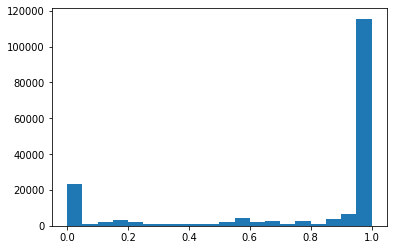

In [20]:
_ = plt.hist(1/(1+np.exp(-normed_protorole_appl[0])), bins=20)

In [21]:
normed_protorole = fit_ordinal_normalizer(protoroles_bulk['Response']-1,
                                          protoroles_bulk['unique_id'].cat.codes,
                                          protoroles_bulk['participant'],
                                          smoothing=1,
                                          iterations=20000)

0 	 -1166295.6 	 183.99998 	 7457464.5 	 0.3693217
1000 	 -213112.12 	 184.00002 	 958679.8 	 0.38099042
2000 	 -194418.84 	 184.0 	 930910.44 	 0.3925163
3000 	 -187741.11 	 184.00002 	 922971.0 	 0.40603408
4000 	 -185201.2 	 183.99997 	 920322.3 	 0.4124585
5000 	 -183959.5 	 184.00003 	 919120.56 	 0.41566426
6000 	 -183412.05 	 183.99998 	 918610.2 	 0.4172857
7000 	 -183182.03 	 184.0 	 918383.8 	 0.41808248
8000 	 -183075.77 	 184.0 	 918274.56 	 0.41838217
9000 	 -183023.83 	 184.00003 	 918221.7 	 0.41855466
10000 	 -182991.64 	 184.0 	 918186.94 	 0.41862455
11000 	 -182981.88 	 183.99998 	 918172.6 	 0.41867253
12000 	 -182958.44 	 184.0 	 918148.94 	 0.418682
13000 	 -182939.9 	 184.0 	 918132.56 	 0.41872886
14000 	 -182914.9 	 183.99998 	 918106.5 	 0.41874787
15000 	 -182889.45 	 183.99997 	 918079.06 	 0.4187009
16000 	 -182878.06 	 184.0 	 918065.6 	 0.4186832
17000 	 -182863.05 	 184.0 	 918048.75 	 0.41875583
18000 	 -182856.31 	 184.0 	 918043.0 	 0.41876918
19000 	

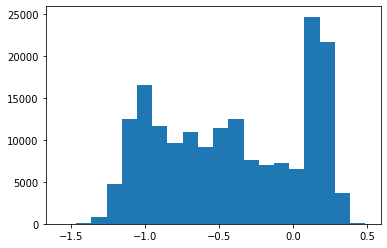

In [22]:
_ = plt.hist(normed_protorole[0], bins=20)

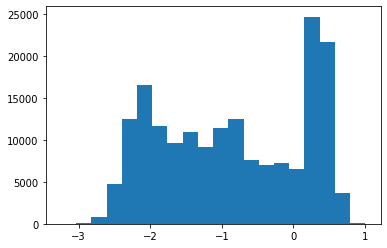

In [23]:
_ = plt.hist(normed_protorole[0]/normed_protorole[0].std(), bins=20)

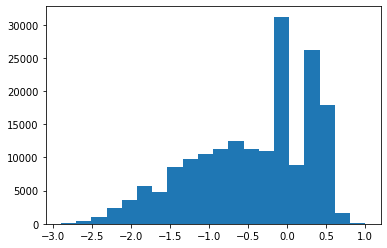

In [24]:
protorole_standardized = normed_protorole[0]/normed_protorole[0].std()
protorole_thresholded = np.maximum(np.minimum(protorole_standardized, 3), -3)
protorole_scaled = protorole_thresholded*1/(1+np.exp(-normed_protorole_appl[0]))

_ = plt.hist(protorole_scaled, bins=20)

In [25]:
protoroles_bulk['normed'] = protorole_scaled

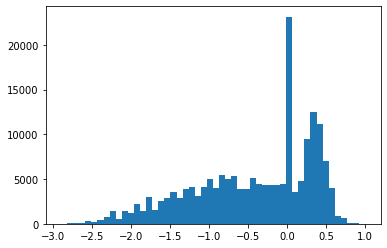

In [26]:
_ = plt.hist(protoroles_bulk['normed'], bins=50)

In [27]:
agg_by = ['Sentence.ID', 'Pred.Lemma', 'Pred.Token', 'Arg.Token', 'Arg.Tokens.Begin', 
          'Arg.Tokens.End', 'Arg.Phrase', 'Gram.Func', 'Property']

protoroles_bulk_agg = protoroles_bulk.pivot_table(index=agg_by, values=['normed']).reset_index()

protoroles_bulk_agg.head()

,Sentence.ID,Pred.Lemma,Pred.Token,Arg.Token,Arg.Tokens.Begin,Arg.Tokens.End,Arg.Phrase,Gram.Func,Property,normed
0,en-ud-dev.conllu 1,come,3,0,0,2,from the ap,nmod,location,0.510157
1,en-ud-dev.conllu 1,come,3,0,0,2,from the ap,nmod,manner,-2.088254
2,en-ud-dev.conllu 1,come,3,0,0,2,from the ap,nmod,purpose,-2.088253
3,en-ud-dev.conllu 1,come,3,0,0,2,from the ap,nmod,time,-2.088253
4,en-ud-dev.conllu 1,come,3,1,4,5,this story,nsubj,awareness,-0.000002


In [28]:
protorole_out = defaultdict(dict)


for (sentid, plemma, ptokid, atokid, atokbeg, atokend, aphrase, gramfunc), df in protoroles_bulk_agg.groupby(agg_by[:-1]):
    fname, position = sentid.split()
    sentname = 'ewt-'+fname.split('.')[0].split('-')[2]+'-'+str(position)
    
    events = [e for e in predpatt[fname][sentname].events if e.position==ptokid]
    
    if len(events)==0:
        print('ERROR: no corresponding event for predicate ', plemma, ptokid, 'in', sentname)
        print()
        print(predpatt[fname][sentname].pprint())
        print()
        continue
    elif len(events)>1:
        print('ERROR: too many events for predicate ', ptokid, 'in', sentname)
        print()
        print(predpatt[fname][sentname].pprint())
        print()
        continue
    
    ev = events[0]
    
    all_args = ev.arguments
    isarg = [aphrase==' '.join([t.text.lower() for t in a.tokens]) for a in all_args]
    
    if sum(isarg)!=1:
        isarg = [a.root.gov_rel==gramfunc for a in all_args]
        if sum(isarg)!=1:
            if aphrase in ['which', 'who', 'that']:
                isarg = [True] + [False]*(len(all_args)-1)
            else:
                argspans = [[t.position
                             for t in a.tokens]
                            for a in all_args]
                isarg = [((min(span)==atokbeg)&(max(span)==atokend))|\
                         all([atokbeg <= t <= atokend for t in span])
                         for span in argspans]
                
                if sum(isarg)!=1:
                    print('ERROR: no corresponding argument for argument', aphrase, atokid,
                          'of predicate', plemma, 'in', sentname)
                    print()
                    print(predpatt[fname][sentname].pprint())
                    print()
                    continue
    
    try:
        argrelpos = np.where(isarg)[0][0]
    except IndexError:
        print('ERROR: no match for', aphrase, atokid,
              'of predicate', plemma, 'in', sentname)
        print()
        print(predpatt[fname][sentname].pprint())
        print()
        continue
    
    arg = all_args[argrelpos]
    
    pair = sentname+'-semantics-pred-'+str(ev.position+1)+'_'+sentname+'-semantics-arg-'+str(arg.position+1)
    
    info = df[['Property', 'normed']].set_index('Property').normed.to_dict()
    
    protorole_out[sentname][pair] = {'protoroles-'+k: round(v,4) for k, v in info.items()}

ERROR: no corresponding argument for argument a taste fresh , locally sourced , fabulously prepared food 1 of predicate offer in ewt-train-10157

	?a offer ?b ?c in ?d
		?a: This French born , French trained chef and his creative partners
		?b: taste
		?c: a fresh , locally sourced , fabulously prepared food
		?d: the most unlikely of locations

ERROR: no corresponding event for predicate  crush 9 in ewt-train-12000

	?a runs ?b ?c
		?a: it
		?b: you
		?c: about 4 bucks
	?a deals ?b to ?c
		?a: it
		?b: crushing blows
		?c: hunger

ERROR: no corresponding argument for argument god 2 of predicate benefit in ewt-train-1397

	?a reported ?b
		?a: The Wall Street Journal
		?b: SOMETHING := a computer used by Zawahiri contains a June 1999 memo that " said the program should seek cover and talent in educational institutions , which it said were ' more beneficial to us and allow easy access to specialists , which will greatly benefit us in the first stage , God willing
	?a used by ?b
		?a: a 

In [29]:
with open('../data/protoroles/protoroles.json', 'w') as f:
    json.dump(protorole_out, f)

## Factuality

In [30]:
factuality = pd.read_csv('../data/factuality/it-happened_eng_ud1.2_07092017.tsv', sep='\t')

factuality.head()

,Split,Annotator.ID,Display.Position,Sentence.ID,Pred.Token,Pred.Lemma,Is.Predicate,Is.Understandable,Happened,Confidence,Keep
0,dev,6,1,en-ud-dev.conllu 780,8,confess,True,True,true,4,True
1,dev,14,1,en-ud-dev.conllu 780,8,confess,True,True,true,4,True
2,dev,7,1,en-ud-dev.conllu 802,11,decide,True,True,true,4,True
3,dev,14,1,en-ud-dev.conllu 802,11,decide,True,True,true,4,True
4,dev,1,1,en-ud-dev.conllu 807,47,add,False,True,na,na,True


In [31]:
factuality['Happened'].value_counts()

true     34122
false    18764
na        1814
Name: Happened, dtype: int64

In [32]:
factuality['Confidence'].value_counts()

4     29309
2     12095
3      9497
1      1913
na     1814
0        72
Name: Confidence, dtype: int64

In [33]:
factuality_appl = factuality[(factuality['Happened']!='na')&(factuality['Confidence']!='na')]

In [34]:
factuality_appl['factual'] = factuality_appl['Happened'].map(lambda x: 1 if x=='true' else 0)

factuality_appl['factual'].value_counts()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


1    34122
0    18764
Name: factual, dtype: int64

In [35]:
factuality_appl['conf'] = factuality_appl['Confidence'].astype(np.int32)

factuality_appl['conf'].value_counts()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


4    29309
2    12095
3     9497
1     1913
0       72
Name: conf, dtype: int64

In [36]:
factuality_appl['unique_id'] = (factuality_appl['Sentence.ID'] + '-' +\
                                factuality_appl['Pred.Token'].astype(str)).astype('category')

factuality_appl['unique_id'].cat.categories

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Index(['en-ud-dev.conllu 1-4', 'en-ud-dev.conllu 100-2',
       'en-ud-dev.conllu 100-21', 'en-ud-dev.conllu 1000-1',
       'en-ud-dev.conllu 1000-10', 'en-ud-dev.conllu 1000-18',
       'en-ud-dev.conllu 1000-24', 'en-ud-dev.conllu 1000-31',
       'en-ud-dev.conllu 1000-6', 'en-ud-dev.conllu 1001-3',
       ...
       'en-ud-train.conllu 9995-34', 'en-ud-train.conllu 9995-51',
       'en-ud-train.conllu 9996-2', 'en-ud-train.conllu 9997-3',
       'en-ud-train.conllu 9998-14', 'en-ud-train.conllu 9998-20',
       'en-ud-train.conllu 9998-6', 'en-ud-train.conllu 9998-8',
       'en-ud-train.conllu 9999-13', 'en-ud-train.conllu 9999-19'],
      dtype='object', length=27403)

In [37]:
factuality_appl['participant'] = factuality_appl['Annotator.ID'].astype('category').cat.codes

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
# normed_factuality_conf = fit_ordinal_normalizer(factuality_appl['conf'],
#                                                 factuality_appl['unique_id'].cat.codes,
#                                                 factuality_appl['participant'],
#                                                 center=False,
#                                                 iterations=15000)

normed_factuality_conf = factuality_appl.groupby('participant').conf.transform(ridit)

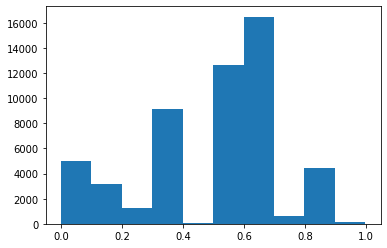

In [39]:
#_ = plt.hist(normed_factuality_conf[0]/normed_factuality_conf[0].mean())

_ = plt.hist(normed_factuality_conf)

In [40]:
normed_factuality_fact = fit_ordinal_normalizer(factuality_appl['factual'],
                                                factuality_appl['unique_id'].cat.codes,
                                                factuality_appl['participant'],
                                                weights=normed_factuality_conf.astype(np.float32),
                                                smoothing=1,
                                                iterations=10000)

0 	 -18329.074 	 47.0 	 56364.035 	 0.50000006
1000 	 -9588.792 	 46.999996 	 49892.973 	 0.68296474
2000 	 -9588.148 	 47.000004 	 49891.77 	 0.6830598
3000 	 -9580.887 	 47.000004 	 49884.043 	 0.68317413
4000 	 -9576.957 	 46.999992 	 49880.773 	 0.6832946
5000 	 -9576.787 	 47.000004 	 49880.734 	 0.68330646
6000 	 -9576.751 	 46.999992 	 49880.805 	 0.6833049
7000 	 -9576.769 	 46.999996 	 49880.883 	 0.68329525
8000 	 -9576.809 	 47.000008 	 49880.69 	 0.6832904
9000 	 -9576.811 	 46.999992 	 49880.86 	 0.6832791


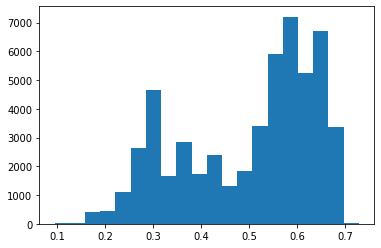

In [41]:
_ = plt.hist(1/(1+np.exp(-normed_factuality_fact[0])), bins=20)

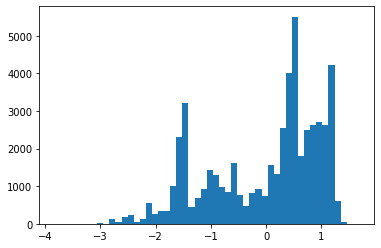

In [42]:
_ = plt.hist(normed_factuality_fact[0]/normed_factuality_fact[0].std(), bins=50)

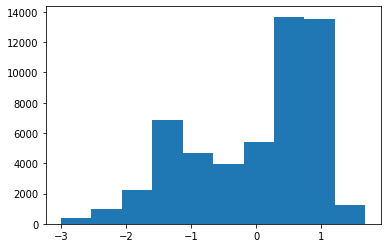

In [43]:
normed_factuality_standardized = normed_factuality_fact[0]/normed_factuality_fact[0].std()
normed_factuality_thresholded = np.minimum(np.maximum(normed_factuality_standardized, -3), 3)

_ = plt.hist(normed_factuality_thresholded)

In [44]:
factuality_appl['normed'] = normed_factuality_thresholded

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


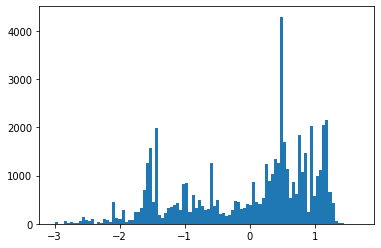

In [45]:
_ = plt.hist(factuality_appl['normed'], bins=100)

In [46]:
agg_by = ['Sentence.ID', 'Pred.Lemma', 'Pred.Token']

factuality_appl_agg = factuality_appl.pivot_table(index=agg_by, values='normed').reset_index()

factuality_appl_agg.head()

,Sentence.ID,Pred.Lemma,Pred.Token,normed
0,en-ud-dev.conllu 1,come,4,0.262697
1,en-ud-dev.conllu 100,cry,2,0.461792
2,en-ud-dev.conllu 100,get,21,-2.506492
3,en-ud-dev.conllu 1000,complete,31,0.769442
4,en-ud-dev.conllu 1000,continue,24,0.769444


In [47]:
factuality_out = defaultdict(dict)

subpredpred = 0
subpredarg = 0
nomatch = 0

for (sentid, plemma, ptokid), df in factuality_appl_agg.groupby(agg_by):
    fname, position = sentid.split()
    sentname = 'ewt-'+fname.split('.')[0].split('-')[2]+'-'+str(position)
    
    events = predpatt[fname][sentname].events
    
    if (ptokid-1) in [e.position for e in predpatt[fname][sentname].events]:
        predid = sentname+'-semantics-pred-'+str(ptokid)
        factuality_out[sentname][predid] = {'factuality-factual': float(df['normed'].values[0])}
        
    else:
        minsize = min([len([t.position for t in a.tokens])
                       for e in events
                       for a in e.arguments]+\
                      [len([t.position for t in e.tokens])
                       for e in events]+[1000000])
        
        inpred = [e.position for e in events
                  if (ptokid-1) in [t.position for t in e.tokens]
                  if len([t.position for t in e.tokens]) == minsize]
        
        inarg = [a.position 
                 for e in events
                 for a in e.arguments
                 if (ptokid-1) in [t.position for t in a.tokens] 
                 if len([t.position for t in a.tokens]) == minsize]
        
        assert not (inpred and inarg)
            
        if inpred:
            predid = sentname+'-semantics-subpred-'+str(ptokid)
            subpredpred += 1
            factuality_out[sentname][predid] = {'factuality-factual': float(df['normed'].values[0]),
                                                'subpredof': sentname+'-semantics-pred-'+str(inpred[0])}
        elif inarg:
            predid = sentname+'-semantics-subpred-'+str(ptokid)
            subpredarg += 1
            factuality_out[sentname][predid] = {'factuality-factual': float(df['normed'].values[0]),
                                                'subpredof': sentname+'-semantics-arg-'+str(inarg[0])}         
        else:
            predid = sentname+'-semantics-pred-'+str(ptokid)
            nomatch += 1
            factuality_out[sentname][predid] = {'factuality-factual': float(df['normed'].values[0])}
            print('ERROR: no matching predicate or argument for', plemma, predid, events)

ERROR: no matching predicate or argument for complete ewt-dev-1000-semantics-pred-31 [Predicate(Listing/0), Predicate(told/5), Predicate(determined/15), Predicate(provide/17), Predicate(continue/23)]
ERROR: no matching predicate or argument for rule ewt-dev-1000-semantics-pred-10 [Predicate(Listing/0), Predicate(told/5), Predicate(determined/15), Predicate(provide/17), Predicate(continue/23)]
ERROR: no matching predicate or argument for escalate ewt-dev-1011-semantics-pred-23 [Predicate(announced/6)]
ERROR: no matching predicate or argument for provoke ewt-dev-110-semantics-pred-35 [Predicate(situation/4), Predicate(evacuated/11), Predicate(hit/18), Predicate(predictable/29), Predicate(rained/37)]
ERROR: no matching predicate or argument for help ewt-dev-1124-semantics-pred-2 []
ERROR: no matching predicate or argument for help ewt-dev-1134-semantics-pred-2 []
ERROR: no matching predicate or argument for steal ewt-dev-1138-semantics-pred-3 [Predicate(google/0)]
ERROR: no matching predi

ERROR: no matching predicate or argument for redline ewt-dev-389-semantics-pred-4 [Predicate(attached/6)]
ERROR: no matching predicate or argument for base ewt-dev-390-semantics-pred-5 [Predicate(revised/1), Predicate(added/9), Predicate(approved/19)]
ERROR: no matching predicate or argument for concern ewt-dev-390-semantics-pred-13 [Predicate(revised/1), Predicate(added/9), Predicate(approved/19)]
ERROR: no matching predicate or argument for include ewt-dev-40-semantics-pred-17 [Predicate(killed/10)]
ERROR: no matching predicate or argument for forward ewt-dev-414-semantics-pred-4 [Predicate(ready/9)]
ERROR: no matching predicate or argument for go ewt-dev-414-semantics-pred-1 [Predicate(ready/9)]
ERROR: no matching predicate or argument for mix ewt-dev-432-semantics-pred-1 []
ERROR: no matching predicate or argument for pledge ewt-dev-436-semantics-pred-3 []
ERROR: no matching predicate or argument for follow ewt-dev-438-semantics-pred-5 [Predicate(type/1), Predicate(go/11), Predicat

ERROR: no matching predicate or argument for use ewt-test-1706-semantics-pred-3 []
ERROR: no matching predicate or argument for blow ewt-test-1720-semantics-pred-4 []
ERROR: no matching predicate or argument for recommend ewt-test-1729-semantics-pred-2 []
ERROR: no matching predicate or argument for run ewt-test-1742-semantics-pred-7 [Predicate(dealership/7)]
ERROR: no matching predicate or argument for get ewt-test-1743-semantics-pred-3 [Predicate(busy/3), Predicate(have/7), Predicate(wait/9), Predicate(orginizied/14), Predicate(are/18)]
ERROR: no matching predicate or argument for pay ewt-test-1743-semantics-pred-25 [Predicate(busy/3), Predicate(have/7), Predicate(wait/9), Predicate(orginizied/14), Predicate(are/18)]
ERROR: no matching predicate or argument for win ewt-test-1744-semantics-pred-1 []
ERROR: no matching predicate or argument for rate ewt-test-1745-semantics-pred-9 [Predicate(Met/13)]
ERROR: no matching predicate or argument for go ewt-test-1758-semantics-pred-4 []
ERROR

ERROR: no matching predicate or argument for execute ewt-train-10866-semantics-pred-5 [Predicate(want/2), Predicate(feature/8), Predicate(love/16)]
ERROR: no matching predicate or argument for accord ewt-train-10880-semantics-pred-11 [Predicate(patient/2), Predicate(adapted/4), Predicate(go/9)]
ERROR: no matching predicate or argument for come ewt-train-10908-semantics-pred-3 []
ERROR: no matching predicate or argument for hang ewt-train-10908-semantics-pred-6 []
ERROR: no matching predicate or argument for stay ewt-train-10915-semantics-pred-1 []
ERROR: no matching predicate or argument for include ewt-train-10918-semantics-pred-20 [Predicate(said/1), Predicate(plugs/5), Predicate(wires/7), Predicate(quoted/10), Predicate(do/15)]
ERROR: no matching predicate or argument for prepare ewt-train-10927-semantics-pred-10 [Predicate(cuisine/4)]
ERROR: no matching predicate or argument for season ewt-train-10927-semantics-pred-12 [Predicate(cuisine/4)]
ERROR: no matching predicate or argument

ERROR: no matching predicate or argument for regard ewt-train-1636-semantics-pred-7 [Predicate(call/4)]
ERROR: no matching predicate or argument for advise ewt-train-1644-semantics-pred-2 []
ERROR: no matching predicate or argument for send ewt-train-1670-semantics-pred-8 [Predicate(get/2)]
ERROR: no matching predicate or argument for regard ewt-train-1688-semantics-pred-2 [Predicate(transmit/11)]
ERROR: no matching predicate or argument for regard ewt-train-1688-semantics-pred-18 [Predicate(transmit/11)]
ERROR: no matching predicate or argument for regard ewt-train-1690-semantics-pred-2 [Predicate(reserves/7), Predicate(monitor/11), Predicate(review/13), Predicate(sent/20), Predicate(received/24)]
ERROR: no matching predicate or argument for regard ewt-train-1691-semantics-pred-2 [Predicate(transmit/11)]
ERROR: no matching predicate or argument for regard ewt-train-1691-semantics-pred-18 [Predicate(transmit/11)]
ERROR: no matching predicate or argument for regard ewt-train-1693-semant

ERROR: no matching predicate or argument for control ewt-train-3541-semantics-pred-52 [Predicate(is/1), Predicate(refute/7), Predicate(deregulate/24), Predicate(based/26), Predicate(is/40), Predicate(turn/42)]
ERROR: no matching predicate or argument for shape ewt-train-3549-semantics-pred-11 [Predicate(mentioned/2), Predicate(want/6), Predicate(include/8)]
ERROR: no matching predicate or argument for follow ewt-train-3591-semantics-pred-13 [Predicate(moving/10)]
ERROR: no matching predicate or argument for approve ewt-train-3595-semantics-pred-24 [Predicate(incorporated/2), Predicate(possible/11), Predicate(trade/15), Predicate(located/20)]
ERROR: no matching predicate or argument for execute ewt-train-3619-semantics-pred-5 [Predicate(received/2), Predicate(dated/14), Predicate(March/15)]
ERROR: no matching predicate or argument for reference ewt-train-3623-semantics-pred-9 [Predicate(appears/1), Predicate(missed/3), Predicate(had/12), Predicate(on/17), Predicate(see/24)]
ERROR: no ma

ERROR: no matching predicate or argument for file ewt-train-5920-semantics-pred-2 []
ERROR: no matching predicate or argument for increase ewt-train-5923-semantics-pred-1 [Predicate(creating/6)]
ERROR: no matching predicate or argument for pollute ewt-train-5937-semantics-pred-22 [Predicate(boosted/4), Predicate(find/18), Predicate(contributed/28)]
ERROR: no matching predicate or argument for project ewt-train-5937-semantics-pred-2 [Predicate(boosted/4), Predicate(find/18), Predicate(contributed/28)]
ERROR: no matching predicate or argument for own ewt-train-5939-semantics-pred-7 [Predicate(ordered/3), Predicate(go/11), Predicate(ensure/15), Predicate(begun/20), Predicate(drilling/21), Predicate(regards/37)]
ERROR: no matching predicate or argument for accord ewt-train-594-semantics-pred-4 [Predicate(launched/11), Predicate(neighboring/24), Predicate(found/30)]
ERROR: no matching predicate or argument for inhabit ewt-train-594-semantics-pred-23 [Predicate(launched/11), Predicate(neighb

ERROR: no matching predicate or argument for estimate ewt-train-7184-semantics-pred-4 [Predicate(describe/8), Predicate(accept/13), Predicate(interpret/22)]
ERROR: no matching predicate or argument for bear ewt-train-7187-semantics-pred-10 [Predicate(describe/6)]
ERROR: no matching predicate or argument for include ewt-train-7191-semantics-pred-7 [Predicate(have/1), Predicate(guy/14)]
ERROR: no matching predicate or argument for flip ewt-train-7283-semantics-pred-25 [Predicate(be/2), Predicate(rid/13), Predicate(have/19), Predicate(show/29)]
ERROR: no matching predicate or argument for get ewt-train-7283-semantics-pred-13 [Predicate(be/2), Predicate(rid/13), Predicate(have/19), Predicate(show/29)]
ERROR: no matching predicate or argument for watch ewt-train-7288-semantics-pred-1 [Predicate(coming/5)]
ERROR: no matching predicate or argument for turn ewt-train-7297-semantics-pred-5 [Predicate(Walk/0)]
ERROR: no matching predicate or argument for follow ewt-train-73-semantics-pred-23 [Pr

ERROR: no matching predicate or argument for rust ewt-train-8499-semantics-pred-1 [Predicate(make/19), Predicate(hard/21), Predicate(dangerous/26)]
ERROR: no matching predicate or argument for tear ewt-train-8499-semantics-pred-3 [Predicate(make/19), Predicate(hard/21), Predicate(dangerous/26)]
ERROR: no matching predicate or argument for include ewt-train-8515-semantics-pred-11 [Predicate(Here/2), Predicate(lists/7)]
ERROR: no matching predicate or argument for expand ewt-train-8538-semantics-pred-10 [Predicate(caucasian/4), Predicate(started/14)]
ERROR: no matching predicate or argument for get ewt-train-8575-semantics-pred-65 [Predicate(made/2), Predicate(took/9), Predicate(put/20), Predicate(filled/38), Predicate(surounded/45), Predicate(lit/50), Predicate(pumped/54), Predicate(hot/66), Predicate(melt/70)]
ERROR: no matching predicate or argument for force ewt-train-8579-semantics-pred-13 [Predicate(hot/4), Predicate(gas/10), Predicate(air/13), Predicate(oxygen/15)]
ERROR: no match

In [48]:
nomatch, subpredpred, subpredarg

(1385, 4, 33)

In [49]:
with open('../data/factuality/factuality.json', 'w') as f:
    json.dump(factuality_out, f)

## Genericity

### Predicate

In [50]:
genericity_pred = pd.read_csv('../data/genericity/pred_long_data.tsv', sep='\t')

genericity_pred.head()

,Split,Annotator.ID,Sentence.ID,Pred.Token,Ann.Token,Pred.Span,Arg.Token,Arg.Span,Pred.Word,Pred.Lemma,Is.Particular,Part.Confidence,Is.Dynamic,Dyn.Confidence,Is.Hypothetical,Hyp.Confidence
0,train,247,en-ud-train.conllu sent_1,7,7,"7,16","6,12,18","5,6;8,9,10,11,12,13,14,15;17,18,19,20,21,22,23...",killed,kill,True,4,True,4,False,4
1,train,247,en-ud-train.conllu sent_2,10,10,"8,9,10,13","3,11,12,14","2,3,4,5,6,7;11;12;14,15,16",causing,cause,False,1,True,2,True,2
2,train,247,en-ud-train.conllu sent_2,16,16,16,14,14,come,come,False,0,True,1,True,2
3,train,247,en-ud-train.conllu sent_3,5,5,5,"4,9","3,4;7,8,9,10,11,12,13,14,15,16",announced,announce,True,4,False,4,False,4
4,train,247,en-ud-train.conllu sent_3,9,9,"8,9,10","7,13","7;11,12,13,14,15,16",busted,bust,True,4,False,4,False,4


In [51]:
genericity_pred_part = genericity_pred[list(genericity_pred.columns[:-6].values)+['Is.Particular', 'Part.Confidence']]
genericity_pred_part['property'] = 'particular'
genericity_pred_part = genericity_pred_part.rename(columns={'Is.Particular': 'response', 
                                                          'Part.Confidence': 'confidence'})

genericity_pred_dyn = genericity_pred[list(genericity_pred.columns[:-6].values)+['Is.Dynamic', 'Dyn.Confidence']]
genericity_pred_dyn['property'] = 'dynamic'
genericity_pred_dyn = genericity_pred_dyn.rename(columns={'Is.Dynamic': 'response', 
                                                          'Dyn.Confidence': 'confidence'})

genericity_pred_hyp = genericity_pred[list(genericity_pred.columns[:-6].values)+['Is.Hypothetical', 'Hyp.Confidence']]
genericity_pred_hyp['property'] = 'hypothetical'
genericity_pred_hyp = genericity_pred_hyp.rename(columns={'Is.Hypothetical': 'response',
                                                        'Hyp.Confidence': 'confidence'})

genericity_pred = pd.concat([genericity_pred_part, genericity_pred_dyn, genericity_pred_hyp])

genericity_pred.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

,Split,Annotator.ID,Sentence.ID,Pred.Token,Ann.Token,Pred.Span,Arg.Token,Arg.Span,Pred.Word,Pred.Lemma,response,confidence,property
0,train,247,en-ud-train.conllu sent_1,7,7,"7,16","6,12,18","5,6;8,9,10,11,12,13,14,15;17,18,19,20,21,22,23...",killed,kill,True,4,particular
1,train,247,en-ud-train.conllu sent_2,10,10,"8,9,10,13","3,11,12,14","2,3,4,5,6,7;11;12;14,15,16",causing,cause,False,1,particular
2,train,247,en-ud-train.conllu sent_2,16,16,16,14,14,come,come,False,0,particular
3,train,247,en-ud-train.conllu sent_3,5,5,5,"4,9","3,4;7,8,9,10,11,12,13,14,15,16",announced,announce,True,4,particular
4,train,247,en-ud-train.conllu sent_3,9,9,"8,9,10","7,13","7;11,12,13,14,15,16",busted,bust,True,4,particular


In [52]:
genericity_pred['response'] = genericity_pred.response.map(lambda x: 1 if x else 0)

genericity_pred['response'].value_counts()

1    70074
0    67626
Name: response, dtype: int64

In [53]:
genericity_pred['response'].isnull().sum()

0

In [54]:
genericity_pred['confidence'].value_counts()

4    90456
2    22585
3    16055
1     5063
0     3541
Name: confidence, dtype: int64

In [55]:
genericity_pred['confidence'].isnull().sum()

0

In [56]:
genericity_pred['unique_id'] = (genericity_pred['Sentence.ID'] + '-' +\
                                genericity_pred['Pred.Token'].astype(str) + '-' +\
                                genericity_pred['property']).astype('category')

genericity_pred['unique_id'].cat.categories

Index(['en-ud-dev.conllu sent_1-4-dynamic',
       'en-ud-dev.conllu sent_1-4-hypothetical',
       'en-ud-dev.conllu sent_1-4-particular',
       'en-ud-dev.conllu sent_100-10-dynamic',
       'en-ud-dev.conllu sent_100-10-hypothetical',
       'en-ud-dev.conllu sent_100-10-particular',
       'en-ud-dev.conllu sent_100-11-dynamic',
       'en-ud-dev.conllu sent_100-11-hypothetical',
       'en-ud-dev.conllu sent_100-11-particular',
       'en-ud-dev.conllu sent_100-2-dynamic',
       ...
       'en-ud-train.conllu sent_9998-6-particular',
       'en-ud-train.conllu sent_9998-8-dynamic',
       'en-ud-train.conllu sent_9998-8-hypothetical',
       'en-ud-train.conllu sent_9998-8-particular',
       'en-ud-train.conllu sent_9999-13-dynamic',
       'en-ud-train.conllu sent_9999-13-hypothetical',
       'en-ud-train.conllu sent_9999-13-particular',
       'en-ud-train.conllu sent_9999-5-dynamic',
       'en-ud-train.conllu sent_9999-5-hypothetical',
       'en-ud-train.conllu sent_9999-

In [57]:
genericity_pred['participant'] = genericity_pred['Annotator.ID'].astype('category').cat.codes

genericity_pred['participant'].value_counts()

436    4830
190    2580
310    2160
302    2070
160    1680
254    1560
178    1560
390    1530
348    1530
261    1500
296    1500
279    1500
380    1500
339    1500
350    1500
53     1500
32     1500
399    1497
417    1470
61     1470
280    1470
219    1467
200    1440
352    1434
360    1410
2      1380
210    1350
9      1230
410    1170
426    1140
       ... 
24       30
407      30
430      30
86       30
214      30
406      30
278      30
283      30
156      30
162      30
287      30
34       30
325      30
70       30
326      30
33       30
327      30
201      30
330      30
159      30
284      30
31       30
331      30
76       30
30       30
205      30
333      30
157      30
334      30
383      30
Name: participant, Length: 437, dtype: int64

In [58]:
# normed_genericity_pred_conf = fit_ordinal_normalizer(genericity_pred['confidence'],
#                                                 genericity_pred['unique_id'].cat.codes,
#                                                 genericity_pred['participant'],
#                                                 center=False,
#                                                 iterations=15000)

normed_genericity_pred_conf = genericity_pred.groupby('participant').confidence.transform(ridit)

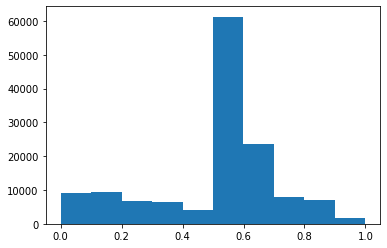

In [59]:
#_ = plt.hist(normed_genericity_pred_conf[0]/normed_genericity_pred_conf[0].mean())
_ = plt.hist(normed_genericity_pred_conf)

In [60]:
normed_genericity_pred_resp = fit_ordinal_normalizer(genericity_pred['response'],
                                                genericity_pred['unique_id'].cat.codes,
                                                genericity_pred['participant'],
                                                weights=normed_genericity_pred_conf.astype(np.float32),
                                                smoothing=1,
                                                iterations=10000)

0 	 -47723.523 	 437.00003 	 185040.94 	 0.5
1000 	 -32495.773 	 437.0001 	 174910.6 	 0.62155956
2000 	 -32495.91 	 437.0 	 174910.62 	 0.6215544
3000 	 -32495.566 	 436.99997 	 174911.64 	 0.6215835
4000 	 -32495.75 	 437.0 	 174910.39 	 0.62155855
5000 	 -32495.713 	 437.00003 	 174910.42 	 0.62155837
6000 	 -32495.9 	 436.99997 	 174911.28 	 0.62154055
7000 	 -32495.74 	 437.00003 	 174910.88 	 0.6215591
8000 	 -32495.672 	 437.0 	 174910.0 	 0.621561
9000 	 -32499.836 	 437.0 	 174919.03 	 0.6216143


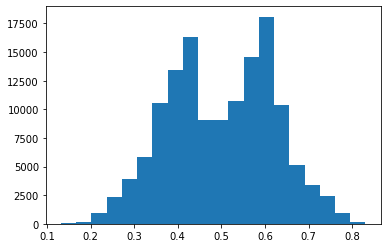

In [61]:
_ = plt.hist(1/(1+np.exp(-normed_genericity_pred_resp[0])), bins=20)

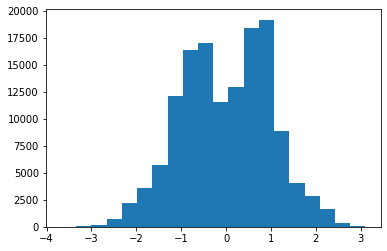

In [62]:
_ = plt.hist(normed_genericity_pred_resp[0]/normed_genericity_pred_resp[0].std(), bins=20)

In [63]:
genericity_pred['normed'] = normed_genericity_pred_resp[0]/normed_genericity_pred_resp[0].std()

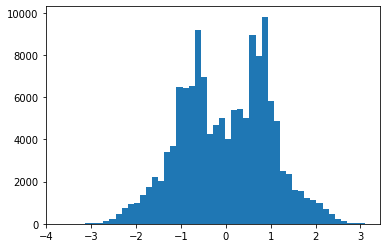

In [64]:
_ = plt.hist(genericity_pred['normed'], bins=50)

In [65]:
agg_by = ['Sentence.ID', 'Pred.Token', 'property']

genericity_pred_agg = genericity_pred.pivot_table(index=agg_by, values='normed').reset_index()

genericity_pred_agg.head()

,Sentence.ID,Pred.Token,property,normed
0,en-ud-dev.conllu sent_1,4,dynamic,-0.236814
1,en-ud-dev.conllu sent_1,4,hypothetical,-0.322275
2,en-ud-dev.conllu sent_1,4,particular,1.913182
3,en-ud-dev.conllu sent_100,2,dynamic,0.881684
4,en-ud-dev.conllu sent_100,2,hypothetical,-1.038059


In [66]:
genericity_out = defaultdict(dict)

for (sentid, ptokid), df in genericity_pred_agg.groupby(agg_by[:-1]):
    fname, position = sentid.replace(' sent', '').split('_')
    sentname = 'ewt-'+fname.split('.')[0].split('-')[2]+'-'+str(position)

    if (ptokid-1) in [e.position for e in predpatt[fname][sentname].events]:
        predid = sentname+'-semantics-pred-'+str(ptokid)
        info = df[['property', 'normed']].set_index('property').normed.to_dict()
        genericity_out[sentname][predid] = {'genericity-pred-'+k: round(v,4) for k, v in info.items()}
    else:
        print('ERROR: no matching predicate for', predid)

### Argument

In [67]:
genericity_arg = pd.read_csv('../data/genericity/arg_long_data.tsv', sep='\t')

genericity_arg.head()

,Split,Annotator.ID,Sentence.ID,Arg.Token,Arg.Span,Pred.Token,Pred.Span,Arg.Word,Arg.Lemma,Is.Particular,Part.Confidence,Is.Kind,Kind.Confidence,Is.Abstract,Abs.Confidence
0,train,180,en-ud-train.conllu sent_4522,32,"30,31,32",29,"29,33",one,one,True,4,True,4,True,4
1,train,180,en-ud-train.conllu sent_4522,41,"35,36,37,38,39,40,41",42,42,SE,SE,True,4,False,4,False,4
2,train,180,en-ud-train.conllu sent_4522,46,"45,46",43,43,bit,bit,False,4,False,4,False,4
3,train,180,en-ud-train.conllu sent_4522,49,49,50,50,you,you,True,4,False,4,False,4
4,train,180,en-ud-train.conllu sent_4523,2,2,3,"1,3,5",you,you,True,4,False,4,False,4


In [68]:
genericity_arg_part = genericity_arg[list(genericity_arg.columns[:-6].values)+['Is.Particular', 'Part.Confidence']]
genericity_arg_part['property'] = 'particular'
genericity_arg_part = genericity_arg_part.rename(columns={'Is.Particular': 'response', 
                                                          'Part.Confidence': 'confidence'})

genericity_arg_kind = genericity_arg[list(genericity_arg.columns[:-6].values)+['Is.Kind', 'Kind.Confidence']]
genericity_arg_kind['property'] = 'kind'
genericity_arg_kind = genericity_arg_kind.rename(columns={'Is.Kind': 'response', 
                                                          'Kind.Confidence': 'confidence'})

genericity_arg_abs = genericity_arg[list(genericity_arg.columns[:-6].values)+['Is.Abstract', 'Abs.Confidence']]
genericity_arg_abs['property'] = 'abstract'
genericity_arg_abs = genericity_arg_abs.rename(columns={'Is.Abstract': 'response',
                                                        'Abs.Confidence': 'confidence'})

genericity_arg = pd.concat([genericity_arg_part, genericity_arg_kind, genericity_arg_abs])

genericity_arg.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

,Split,Annotator.ID,Sentence.ID,Arg.Token,Arg.Span,Pred.Token,Pred.Span,Arg.Word,Arg.Lemma,response,confidence,property
0,train,180,en-ud-train.conllu sent_4522,32,"30,31,32",29,"29,33",one,one,True,4,particular
1,train,180,en-ud-train.conllu sent_4522,41,"35,36,37,38,39,40,41",42,42,SE,SE,True,4,particular
2,train,180,en-ud-train.conllu sent_4522,46,"45,46",43,43,bit,bit,False,4,particular
3,train,180,en-ud-train.conllu sent_4522,49,49,50,50,you,you,True,4,particular
4,train,180,en-ud-train.conllu sent_4523,2,2,3,"1,3,5",you,you,True,4,particular


In [69]:
genericity_arg['response'] = genericity_arg.response.map(lambda x: 1 if x else 0)

genericity_arg['response'].value_counts()

0    90031
1    64073
Name: response, dtype: int64

In [70]:
genericity_arg['response'].isnull().sum()

0

In [71]:
genericity_arg['confidence'].value_counts()

4    119794
2     16622
3     11398
0      3367
1      2923
Name: confidence, dtype: int64

In [72]:
genericity_arg['confidence'].isnull().sum()

0

In [73]:
genericity_arg['unique_id'] = (genericity_arg['Sentence.ID'] + '-' +\
                                genericity_arg['Arg.Token'].astype(str) + '-' +\
                                genericity_arg['property']).astype('category')

genericity_arg['unique_id'].cat.categories

Index(['en-ud-dev.conllu sent_1-3-abstract', 'en-ud-dev.conllu sent_1-3-kind',
       'en-ud-dev.conllu sent_1-3-particular',
       'en-ud-dev.conllu sent_1-6-abstract', 'en-ud-dev.conllu sent_1-6-kind',
       'en-ud-dev.conllu sent_1-6-particular',
       'en-ud-dev.conllu sent_100-1-abstract',
       'en-ud-dev.conllu sent_100-1-kind',
       'en-ud-dev.conllu sent_100-1-particular',
       'en-ud-dev.conllu sent_100-18-abstract',
       ...
       'en-ud-train.conllu sent_9999-12-particular',
       'en-ud-train.conllu sent_9999-15-abstract',
       'en-ud-train.conllu sent_9999-15-kind',
       'en-ud-train.conllu sent_9999-15-particular',
       'en-ud-train.conllu sent_9999-20-abstract',
       'en-ud-train.conllu sent_9999-20-kind',
       'en-ud-train.conllu sent_9999-20-particular',
       'en-ud-train.conllu sent_9999-6-abstract',
       'en-ud-train.conllu sent_9999-6-kind',
       'en-ud-train.conllu sent_9999-6-particular'],
      dtype='object', length=111438)

In [74]:
genericity_arg['participant'] = genericity_arg['Annotator.ID'].astype('category').cat.codes

genericity_arg['participant'].value_counts()

458    2490
209    2070
413    1917
142    1620
11     1590
469    1530
412    1530
379    1530
419    1500
425    1500
164    1500
461    1500
51     1500
427    1500
37     1500
166    1500
249    1500
262    1500
5      1500
128    1500
325    1500
231    1500
154    1500
199    1470
316    1440
293    1290
446    1260
449    1230
354    1200
474    1140
       ... 
28       30
411      30
218      30
345      30
300      30
165      30
172      30
44       30
83       30
467      30
43       30
212      30
298      30
170      30
213      30
297      30
169      30
41       30
424      30
214      30
87       30
215      30
39       30
422      30
294      30
344      30
472      30
421      30
217      30
113       6
Name: participant, Length: 481, dtype: int64

In [75]:
# normed_genericity_arg_conf = fit_ordinal_normalizer(genericity_arg['confidence'],
#                                                 genericity_arg['unique_id'].cat.codes,
#                                                 genericity_arg['participant'],
#                                                 center=False,
#                                                 iterations=15000)

normed_genericity_arg_conf = genericity_arg.groupby('participant').confidence.transform(ridit)

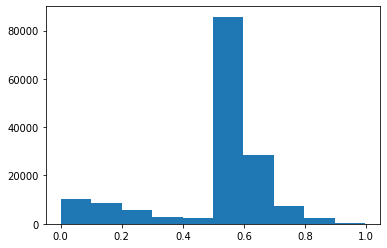

In [76]:
#_ = plt.hist(normed_genericity_arg_conf[0]/normed_genericity_arg_conf[0].mean())
_ = plt.hist(normed_genericity_arg_conf)

In [77]:
normed_genericity_arg_resp = fit_ordinal_normalizer(genericity_arg['response'],
                                                genericity_arg['unique_id'].cat.codes,
                                                genericity_arg['participant'],
                                                weights=normed_genericity_arg_conf.astype(np.float32),
                                                smoothing=1,
                                                iterations=10000)

0 	 -53408.86 	 480.99988 	 208379.02 	 0.49999994
1000 	 -35392.82 	 481.00006 	 196415.72 	 0.63072115
2000 	 -35388.26 	 480.99985 	 196412.98 	 0.63086843
3000 	 -35387.52 	 481.0 	 196412.36 	 0.63086396
4000 	 -35388.742 	 481.00006 	 196411.9 	 0.6307962
5000 	 -35388.24 	 480.9999 	 196412.84 	 0.63087237
6000 	 -35388.32 	 480.99994 	 196413.44 	 0.6308751
7000 	 -35388.3 	 480.99997 	 196412.98 	 0.630938
8000 	 -35388.223 	 481.0 	 196412.94 	 0.6308705
9000 	 -35388.145 	 480.99997 	 196412.73 	 0.6309284


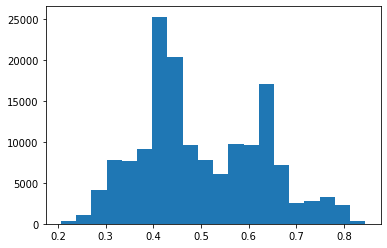

In [78]:
_ = plt.hist(1/(1+np.exp(-normed_genericity_arg_resp[0])), bins=20)

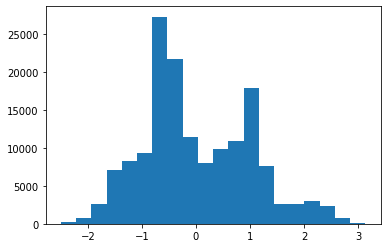

In [79]:
_ = plt.hist(normed_genericity_arg_resp[0]/normed_genericity_arg_resp[0].std(), bins=20)

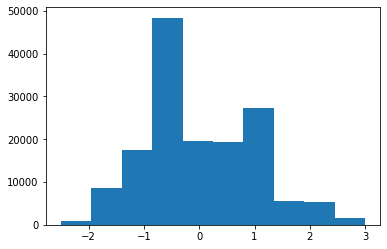

In [80]:
normed_genericity_arg_resp_standardized = normed_genericity_arg_resp[0]/normed_genericity_arg_resp[0].std()
normed_genericity_arg_resp_thresholded = np.maximum(np.minimum(normed_genericity_arg_resp_standardized, 3), -3)

_ = plt.hist(normed_genericity_arg_resp_thresholded)

In [81]:
genericity_arg['normed'] = normed_genericity_arg_resp_thresholded

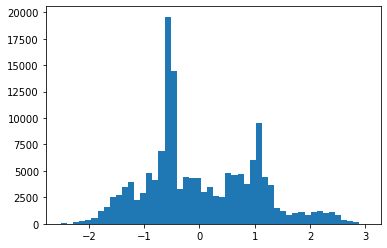

In [82]:
_ = plt.hist(genericity_arg['normed'], bins=50)

In [83]:
agg_by = ['Sentence.ID', 'Arg.Token', 'property']

genericity_arg_agg = genericity_arg.pivot_table(index=agg_by, values='normed').reset_index()

genericity_arg_agg.head()

,Sentence.ID,Arg.Token,property,normed
0,en-ud-dev.conllu sent_1,3,abstract,-1.683454
1,en-ud-dev.conllu sent_1,3,kind,-1.683456
2,en-ud-dev.conllu sent_1,3,particular,2.516607
3,en-ud-dev.conllu sent_1,6,abstract,-1.392735
4,en-ud-dev.conllu sent_1,6,kind,-0.149258


We handle copular predicates with nominal complements such as *is a small country* in *Iguazu is a small country* (`ewt-dev-1030`) by annotating *is a small country* as a predicate and *a small country* as an argument. These arguments will be connected to the copular predicate by a `head` edge. This is the inverse of what happens in the case of clausal arguments, where the predicate that heads the clausal complement is the head of that argument.

In [84]:
for (sentid, atokid), df in genericity_arg_agg.groupby(agg_by[:-1]):
    fname, position = sentid.replace(' sent', '').split('_')
    sentname = 'ewt-'+fname.split('.')[0].split('-')[2]+'-'+str(position)
    
    possible_subarg = (atokid-1) not in [a.position
                                         for e in predpatt[fname][sentname].events
                                         for a in e.arguments]
    
    if possible_subarg:
        headofpred = (atokid-1) in [e.position for e in predpatt[fname][sentname].events]
        
        if headofpred:
            argid = sentname+'-semantics-arg-'+str(atokid)
            info = df[['property', 'normed']].set_index('property').normed.to_dict()
            genericity_out[sentname][argid] = {'genericity-arg-'+k: round(v,4) for k, v in info.items()}
            genericity_out[sentname][argid]['headof'] = sentname+'-semantics-pred-'+str(atokid)
        else:
            print('ERROR: no matching argument or predicate for', argid)
    
    else:
        argid = sentname+'-semantics-arg-'+str(atokid)
        info = df[['property', 'normed']].set_index('property').normed.to_dict()
        genericity_out[sentname][argid] = {'genericity-arg-'+k: round(v,4) for k, v in info.items()}

In [85]:
with open('../data/genericity/genericity.json', 'w') as f:
    json.dump(genericity_out, f)

## Time

In [86]:
time = pd.read_csv('../data/time/time_eng_ud_v1.2_2015_10_30.tsv', sep='\t')

time.head()

,Split,Annotator.ID,Sentence1.ID,Pred1.Span,Pred1.Token,Event1.ID,Sentence2.ID,Pred2.Span,Pred2.Token,Event2.ID,...,Pred1.Duration,Pred2.Duration,Pred1.Beg,Pred1.End,Pred2.Beg,Pred2.End,Pred1.Duration.Confidence,Pred2.Duration.Confidence,Relation.Confidence,Document.ID
0,train,209,en-ud-train.conllu 418,17,17,en-ud-train.conllu 418_17,en-ud-train.conllu 418,18_19,19,en-ud-train.conllu 418_19,...,2,0,35,41,64,65,4.0,4.0,4.0,10
1,train,209,en-ud-train.conllu 9490,51,51,en-ud-train.conllu 9490_51,en-ud-train.conllu 9490,53,53,en-ud-train.conllu 9490_53,...,6,6,0,65,0,65,4.0,4.0,4.0,189
2,train,209,en-ud-train.conllu 7143,8,8,en-ud-train.conllu 7143_8,en-ud-train.conllu 7144,11_12_13_14_15_18_19,14,en-ud-train.conllu 7144_14,...,7,7,0,81,0,81,4.0,4.0,4.0,83
3,train,209,en-ud-train.conllu 7786,17,17,en-ud-train.conllu 7786_17,en-ud-train.conllu 7787,4_5_6_7_8_9,9,en-ud-train.conllu 7787_9,...,2,10,35,44,0,100,4.0,4.0,4.0,126
4,train,209,en-ud-train.conllu 5729,4,4,en-ud-train.conllu 5729_4,en-ud-train.conllu 5729,36,36,en-ud-train.conllu 5729_36,...,2,7,36,42,0,26,4.0,4.0,4.0,65


### Duration

In [87]:
shared_head = []

time_dur1 = time[['Annotator.ID', 'Sentence1.ID', 'Pred1.Token', 'Pred1.Duration', 'Pred1.Duration.Confidence']]
time_dur2 = time[['Annotator.ID', 'Sentence2.ID', 'Pred2.Token', 'Pred2.Duration', 'Pred2.Duration.Confidence']]

time_dur = pd.concat([time_dur1.rename(columns=lambda x: x.replace('1', '')), 
                      time_dur2.rename(columns=lambda x: x.replace('2', ''))])

time_dur.head()

,Annotator.ID,Sentence.ID,Pred.Token,Pred.Duration,Pred.Duration.Confidence
0,209,en-ud-train.conllu 418,17,2,4.0
1,209,en-ud-train.conllu 9490,51,6,4.0
2,209,en-ud-train.conllu 7143,8,7,4.0
3,209,en-ud-train.conllu 7786,17,2,4.0
4,209,en-ud-train.conllu 5729,4,2,4.0


In [88]:
time_dur['unique_id'] = (time_dur['Sentence.ID'] + '-' +\
                         time_dur['Pred.Token'].astype(str)).astype('category')

time_dur['unique_id'].cat.categories

Index(['en-ud-dev.conllu 1-3', 'en-ud-dev.conllu 100-1',
       'en-ud-dev.conllu 100-10', 'en-ud-dev.conllu 100-20',
       'en-ud-dev.conllu 100-9', 'en-ud-dev.conllu 1000-0',
       'en-ud-dev.conllu 1000-15', 'en-ud-dev.conllu 1000-17',
       'en-ud-dev.conllu 1000-23', 'en-ud-dev.conllu 1000-5',
       ...
       'en-ud-train.conllu 9995-25', 'en-ud-train.conllu 9995-33',
       'en-ud-train.conllu 9995-50', 'en-ud-train.conllu 9997-2',
       'en-ud-train.conllu 9998-13', 'en-ud-train.conllu 9998-19',
       'en-ud-train.conllu 9998-5', 'en-ud-train.conllu 9998-7',
       'en-ud-train.conllu 9999-12', 'en-ud-train.conllu 9999-4'],
      dtype='object', length=32302)

In [89]:
time_dur['participant'] = time_dur['Annotator.ID'].astype('category').cat.codes

time_dur['participant'].value_counts()

619    23672
310    18536
71      9570
211     6070
63      5630
91      4310
713     3720
269     3512
653     3380
96      3110
169     3100
427     3080
107     3040
414     3000
508     2620
448     2610
433     2100
333     2010
5       1800
209     1660
108     1570
548     1410
575     1350
742     1310
361     1280
591     1270
642     1190
549     1120
186      970
722      950
       ...  
337       10
327       10
582       10
190       10
450       10
446       10
574       10
702       10
319       10
511       10
703       10
192       10
576       10
704       10
705       10
66        10
578       10
454       10
706       10
195       10
323       10
579       10
707       10
196       10
324       10
580       10
197       10
581       10
70        10
0         10
Name: participant, Length: 765, dtype: int64

In [90]:
# normed_time_dur_conf = fit_ordinal_normalizer(time_dur['Pred.Duration.Confidence'],
#                                                 time_dur['unique_id'].cat.codes,
#                                                 time_dur['participant'],
#                                                 center=False,
#                                                 iterations=15000)

normed_time_dur_conf = time_dur.groupby('participant')['Pred.Duration.Confidence'].transform(ridit)

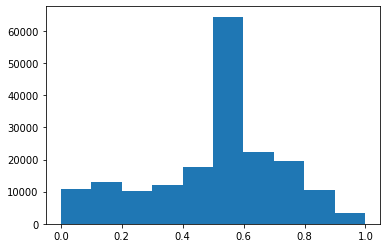

In [91]:
_ = plt.hist(normed_time_dur_conf)

In [92]:
normed_time_dur_resp = fit_multinomial_normalizer(time_dur['Pred.Duration'].values,
                                                  time_dur['unique_id'].cat.codes,
                                                  time_dur['participant'],
                                                  weights=normed_time_dur_conf.astype(np.float32),
                                                  #smoothing=0.1,
                                                  iterations=10000)

0 	 220407.42 	 8414.999 	 228822.42
1000 	 67088.16 	 8415.0 	 75503.16
2000 	 67050.76 	 8415.002 	 75465.76
3000 	 67043.164 	 8415.003 	 75458.164
4000 	 67039.125 	 8415.0 	 75454.125
5000 	 67037.41 	 8415.002 	 75452.41
6000 	 67037.05 	 8415.0 	 75452.05
7000 	 67036.305 	 8415.0 	 75451.305
8000 	 67036.56 	 8415.001 	 75451.56
9000 	 67036.64 	 8414.995 	 75451.63


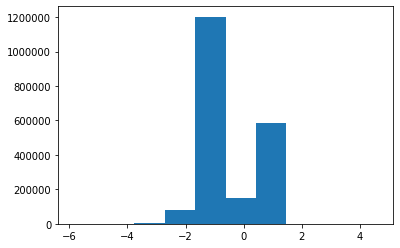

In [93]:
_ = plt.hist(normed_time_dur_resp[0].flatten()/normed_time_dur_resp[0].std())

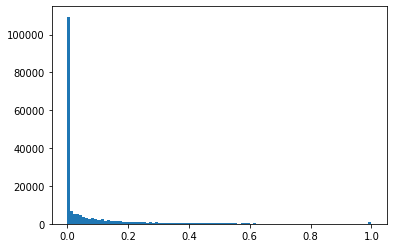

In [94]:
from scipy.special import softmax

_ = plt.hist(softmax(normed_time_dur_resp[0], axis=1)[:,6], bins=100)

In [95]:
normed_time_dur_resp_df = pd.DataFrame(normed_time_dur_resp[0]/normed_time_dur_resp[0].std(), 
                                       index=time_dur.index, 
                                       columns=['instant', 'seconds', 'minutes', 'hours', 
                                                'days', 'weeks', 'months', 'years', 'decades',
                                               'centuries', 'forever'])

normed_time_dur_resp_df.head()

,instant,seconds,minutes,hours,days,weeks,months,years,decades,centuries,forever
0,-0.999273,-1.158023,1.282820,-1.172761,-1.285423,-1.401204,-1.389677,-1.293057,-1.422912,-1.166069,-1.089781
1,-1.340236,-1.396614,-1.200011,0.736495,-1.466840,-1.588203,0.482097,0.206278,0.656109,0.877850,0.774282
2,-1.706458,-0.985333,-0.963574,-1.181448,-1.214738,-1.377090,0.786100,1.010224,0.640227,-1.068633,-0.965337
3,-2.030665,-1.313968,1.147138,0.826328,0.609483,-1.428362,-1.367224,-1.207086,-1.333181,-1.121240,-1.174385
4,-0.937513,0.797554,1.115887,-1.114427,0.835069,-1.396732,-1.329584,-1.210490,-1.422628,-1.301896,-1.153736


In [96]:
time_dur_normed = pd.concat([time_dur, normed_time_dur_resp_df], axis=1)

time_dur_normed.head()

,Annotator.ID,Sentence.ID,Pred.Token,Pred.Duration,Pred.Duration.Confidence,unique_id,participant,instant,seconds,minutes,hours,days,weeks,months,years,decades,centuries,forever
0,209,en-ud-train.conllu 418,17,2,4.0,en-ud-train.conllu 418-17,209,-0.999273,-1.158023,1.282820,-1.172761,-1.285423,-1.401204,-1.389677,-1.293057,-1.422912,-1.166069,-1.089781
1,209,en-ud-train.conllu 9490,51,6,4.0,en-ud-train.conllu 9490-51,209,-1.340236,-1.396614,-1.200011,0.736495,-1.466840,-1.588203,0.482097,0.206278,0.656109,0.877850,0.774282
2,209,en-ud-train.conllu 7143,8,7,4.0,en-ud-train.conllu 7143-8,209,-1.706458,-0.985333,-0.963574,-1.181448,-1.214738,-1.377090,0.786100,1.010224,0.640227,-1.068633,-0.965337
3,209,en-ud-train.conllu 7786,17,2,4.0,en-ud-train.conllu 7786-17,209,-2.030665,-1.313968,1.147138,0.826328,0.609483,-1.428362,-1.367224,-1.207086,-1.333181,-1.121240,-1.174385
4,209,en-ud-train.conllu 5729,4,2,4.0,en-ud-train.conllu 5729-4,209,-0.937513,0.797554,1.115887,-1.114427,0.835069,-1.396732,-1.329584,-1.210490,-1.422628,-1.301896,-1.153736


In [97]:
time_dur_normed_melted = pd.melt(time_dur_normed, id_vars=time_dur.columns, var_name='duration', value_name='normed')

time_dur_normed_melted.head()

,Annotator.ID,Sentence.ID,Pred.Token,Pred.Duration,Pred.Duration.Confidence,unique_id,participant,duration,normed
0,209,en-ud-train.conllu 418,17,2,4.0,en-ud-train.conllu 418-17,209,instant,-0.999273
1,209,en-ud-train.conllu 9490,51,6,4.0,en-ud-train.conllu 9490-51,209,instant,-1.340236
2,209,en-ud-train.conllu 7143,8,7,4.0,en-ud-train.conllu 7143-8,209,instant,-1.706458
3,209,en-ud-train.conllu 7786,17,2,4.0,en-ud-train.conllu 7786-17,209,instant,-2.030665
4,209,en-ud-train.conllu 5729,4,2,4.0,en-ud-train.conllu 5729-4,209,instant,-0.937513


In [98]:
agg_by = ['Sentence.ID', 'Pred.Token', 'duration']

time_dur_agg = time_dur_normed_melted.pivot_table(index=agg_by, values='normed').reset_index()

time_dur_agg.head()

,Sentence.ID,Pred.Token,duration,normed
0,en-ud-dev.conllu 1,3,centuries,-1.170530
1,en-ud-dev.conllu 1,3,days,0.857583
2,en-ud-dev.conllu 1,3,decades,-1.114534
3,en-ud-dev.conllu 1,3,forever,-1.462461
4,en-ud-dev.conllu 1,3,hours,0.993747


In [99]:
time_out = defaultdict(dict)

for (sentid, ptokid), df in time_dur_agg.groupby(agg_by[:-1]):
    fname, position = sentid.split()
    sentname = 'ewt-'+fname.split('.')[0].split('-')[2]+'-'+str(position)
    
    if ptokid in [e.position for e in predpatt[fname][sentname].events]:
        predid = sentname+'-semantics-pred-'+str(ptokid+1)
        info = df[['duration', 'normed']].set_index('duration').normed.to_dict()
        time_out[sentname][predid] = {'time-dur-'+k: round(v, 4) for k, v in info.items()}
    else:
        print('ERROR: no predicate found for', ptokid, 'in', sentname)

In [100]:
time_out

defaultdict(dict,
            {'ewt-dev-1': {'ewt-dev-1-semantics-pred-4': {'time-dur-centuries': -1.1705,
               'time-dur-days': 0.8576,
               'time-dur-decades': -1.1145,
               'time-dur-forever': -1.4625,
               'time-dur-hours': 0.9937,
               'time-dur-instant': -1.4102,
               'time-dur-minutes': -0.9328,
               'time-dur-months': -1.2142,
               'time-dur-seconds': 0.8932,
               'time-dur-weeks': -1.3236,
               'time-dur-years': 0.9253}},
             'ewt-dev-100': {'ewt-dev-100-semantics-pred-10': {'time-dur-centuries': -0.9825,
               'time-dur-days': -1.0618,
               'time-dur-decades': 2.2348,
               'time-dur-forever': -0.9616,
               'time-dur-hours': -0.9097,
               'time-dur-instant': 0.3431,
               'time-dur-minutes': -0.8298,
               'time-dur-months': -0.8377,
               'time-dur-seconds': -1.4301,
               'time-dur-we

In [101]:
with open('../data/time/time.json', 'w') as f:
    json.dump(time_out, f)

### Relation

There is no natural method for aggregating event-event relation data, and so we do not include it in this release.

In [102]:
# time.head()

,Split,Annotator.ID,Sentence1.ID,Pred1.Span,Pred1.Token,Event1.ID,Sentence2.ID,Pred2.Span,Pred2.Token,Event2.ID,...,Pred1.Duration,Pred2.Duration,Pred1.Beg,Pred1.End,Pred2.Beg,Pred2.End,Pred1.Duration.Confidence,Pred2.Duration.Confidence,Relation.Confidence,Document.ID
0,train,209,en-ud-train.conllu 418,17,17,en-ud-train.conllu 418_17,en-ud-train.conllu 418,18_19,19,en-ud-train.conllu 418_19,...,2,0,35,41,64,65,4.0,4.0,4.0,10
1,train,209,en-ud-train.conllu 9490,51,51,en-ud-train.conllu 9490_51,en-ud-train.conllu 9490,53,53,en-ud-train.conllu 9490_53,...,6,6,0,65,0,65,4.0,4.0,4.0,189
2,train,209,en-ud-train.conllu 7143,8,8,en-ud-train.conllu 7143_8,en-ud-train.conllu 7144,11_12_13_14_15_18_19,14,en-ud-train.conllu 7144_14,...,7,7,0,81,0,81,4.0,4.0,4.0,83
3,train,209,en-ud-train.conllu 7786,17,17,en-ud-train.conllu 7786_17,en-ud-train.conllu 7787,4_5_6_7_8_9,9,en-ud-train.conllu 7787_9,...,2,10,35,44,0,100,4.0,4.0,4.0,126
4,train,209,en-ud-train.conllu 5729,4,4,en-ud-train.conllu 5729_4,en-ud-train.conllu 5729,36,36,en-ud-train.conllu 5729_36,...,2,7,36,42,0,26,4.0,4.0,4.0,65


In this release we do not include cross-sentential temporal relations.

In [109]:
# for (sentid1, ptokid1, sentid2, ptokid2), df in time.groupby(['Sentence1.ID', 'Pred1.Token', 'Sentence2.ID', 'Pred2.Token']):
#     fname1, position1 = sentid1.split()
#     fname2, position2 = sentid2.split()
    
#     if position1 == position2: # only intrasentential
#         sentname1 = 'ewt-'+fname1.split('.')[0].split('-')[2]+'-'+str(position1)
#         sentname2 = 'ewt-'+fname2.split('.')[0].split('-')[2]+'-'+str(position2)
        
#         event1 = [e for e in predpatt[fname1][sentname1].events if e.position==ptokid1]
#         event2 = [e for e in predpatt[fname2][sentname2].events if e.position==ptokid2]

#         assert len(event1)==1
#         assert len(event2)==1

#         predid1 = sentname+'-semantics-pred-'+str(event1[0].position)
#         predid2 = sentname+'-semantics-pred-'+str(event2[0].position)
        
#         predpair = predid1+'_'+predid2
        
#         rel = df[['Pred1.Beg', 'Pred1.End', 'Pred2.Beg', 'Pred2.End']].values
#         rel = rel - rel.min(axis=1)[:,None]
#         rel = rel/rel.max(axis=1)[:,None]
        
#         time_out[sentname][predpair] = df[['duration', 'normed']].set_index('duration').normed.to_dict()

## Word Sense

In [6]:
wordsense = pd.read_csv('../data/wordsense/wsd_eng_ud1.2_10262016.tsv', sep='\t')

wordsense.head()

,Split,Annotator.ID,Sentence.ID,Arg.Token,Arg.Lemma,Synset,Sense.Definition,Sense.Response,First.Synset,Display.Position
0,train,0,en-ud-train.conllu 1364,13,spring,spring.n.01,the season of growth,True,spring.n.01,6
1,train,0,en-ud-train.conllu 1364,13,spring,spring.n.02,a metal elastic device that returns to its sha...,False,spring.n.01,4
2,train,0,en-ud-train.conllu 1364,13,spring,spring.n.03,a natural flow of ground water,False,spring.n.01,2
3,train,0,en-ud-train.conllu 1364,13,spring,spring.n.04,a point at which water issues forth,False,spring.n.01,1
4,train,0,en-ud-train.conllu 1364,13,spring,give.n.01,the elasticity of something that can be stretc...,False,spring.n.01,3


In [7]:
wordsense['response'] = wordsense['Sense.Response'].map(lambda x: 1 if x else 0)

wordsense['response'].value_counts()

0    331649
1    107663
Name: response, dtype: int64

In [8]:
wordsense['response'].isnull().sum()

0

In [9]:
wordsense['unique_id'] = (wordsense['Sentence.ID'] + '-' +\
                            wordsense['Arg.Token'].astype(str) + '-' +\
                                wordsense['Synset']).astype('category')

wordsense['unique_id'].cat.categories

Index(['en-ud-dev.conllu 1-6-fib.n.01', 'en-ud-dev.conllu 1-6-floor.n.02',
       'en-ud-dev.conllu 1-6-history.n.02',
       'en-ud-dev.conllu 1-6-narrative.n.01',
       'en-ud-dev.conllu 1-6-report.n.03', 'en-ud-dev.conllu 1-6-story.n.02',
       'en-ud-dev.conllu 100-18-beast.n.02',
       'en-ud-dev.conllu 100-18-wolf.n.01',
       'en-ud-dev.conllu 100-18-wolf.n.02',
       'en-ud-dev.conllu 100-18-wolf.n.03',
       ...
       'en-ud-train.conllu 9999-15-flower.n.02',
       'en-ud-train.conllu 9999-15-flower.n.03',
       'en-ud-train.conllu 9999-20-endowment.n.01',
       'en-ud-train.conllu 9999-20-gift.n.01',
       'en-ud-train.conllu 9999-20-giving.n.01',
       'en-ud-train.conllu 9999-6-confusion.n.01',
       'en-ud-train.conllu 9999-6-confusion.n.02',
       'en-ud-train.conllu 9999-6-confusion.n.03',
       'en-ud-train.conllu 9999-6-confusion.n.04',
       'en-ud-train.conllu 9999-6-confusion.n.05'],
      dtype='object', length=112729)

In [10]:
wordsense['participant'] = wordsense['Annotator.ID'].astype('category').cat.codes

wordsense['participant'].value_counts()

6       4742
117     4673
53      4232
70      3950
73      3936
173     3592
55      3399
1       3207
9       3195
225     3024
423     2948
5       2936
72      2736
3       2713
102     2628
153     2624
22      2579
42      2502
94      2447
310     2265
349     2240
109     2220
254     2207
8       2174
52      2121
303     2089
637     2080
890     2044
667     2040
853     2031
        ... 
635        4
619        4
812        4
954        4
932        4
920        4
909        4
634        4
617        3
1000       3
971        3
949        3
628        3
1029       3
607        3
594        3
593        3
1051       3
613        2
271        2
629        2
119        2
599        2
559        2
1015       2
1023       2
612        1
836        1
820        1
754        1
Name: participant, Length: 1059, dtype: int64

In [11]:
normed_wordsense = fit_ordinal_normalizer(wordsense['response'],
                                          wordsense['unique_id'].cat.codes,
                                          wordsense['participant'],
                                          smoothing=1,
                                          iterations=10000)

0 	 -304556.5 	 1058.9999 	 461894.9 	 0.5
1000 	 -118470.46 	 1059.0002 	 311548.8 	 0.7962297
2000 	 -117245.14 	 1058.9998 	 310440.8 	 0.7980757
3000 	 -116932.33 	 1059.0 	 310360.5 	 0.79894656
4000 	 -116923.64 	 1059.0 	 310360.25 	 0.798981
5000 	 -116912.7 	 1058.9999 	 310360.47 	 0.79896957
6000 	 -116921.92 	 1059.0 	 310360.2 	 0.79898375
7000 	 -116924.97 	 1058.9999 	 310360.25 	 0.79900426
8000 	 -116918.12 	 1059.0 	 310368.6 	 0.798552
9000 	 -116922.58 	 1058.9996 	 310360.62 	 0.79888284


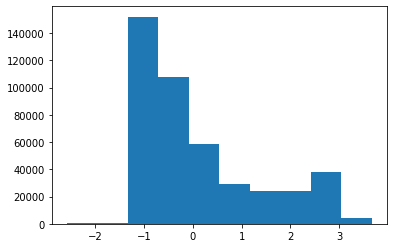

In [12]:
_ = plt.hist(normed_wordsense[0])

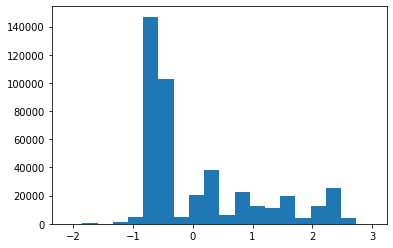

In [13]:
_ = plt.hist(np.minimum(np.maximum(normed_wordsense[0]/normed_wordsense[0].std(), -3), 3), bins=20)

In [14]:
wordsense['normed'] = np.minimum(np.maximum(normed_wordsense[0]/normed_wordsense[0].std(), -3), 3)

In [15]:
agg_by = ['Sentence.ID', 'Arg.Token', 'Arg.Lemma', 'Synset']

wordsense_agg = wordsense.pivot_table(index=agg_by, values='normed').reset_index()

wordsense_agg.head()

,Sentence.ID,Arg.Token,Arg.Lemma,Synset,normed
0,en-ud-dev.conllu 1,6,story,fib.n.01,-0.578910
1,en-ud-dev.conllu 1,6,story,floor.n.02,-0.578909
2,en-ud-dev.conllu 1,6,story,history.n.02,0.930853
3,en-ud-dev.conllu 1,6,story,narrative.n.01,0.930853
4,en-ud-dev.conllu 1,6,story,report.n.03,1.572157


In [16]:
supersenses = np.unique([synset.lexname() for synset in wn.all_synsets() if 'noun' in synset.lexname()])

supersenses

array(['noun.Tops', 'noun.act', 'noun.animal', 'noun.artifact',
       'noun.attribute', 'noun.body', 'noun.cognition',
       'noun.communication', 'noun.event', 'noun.feeling', 'noun.food',
       'noun.group', 'noun.location', 'noun.motive', 'noun.object',
       'noun.person', 'noun.phenomenon', 'noun.plant', 'noun.possession',
       'noun.process', 'noun.quantity', 'noun.relation', 'noun.shape',
       'noun.state', 'noun.substance', 'noun.time'], dtype='<U18')

In [27]:
def compute_supersenses(sense_dict, minval=float(wordsense_agg.normed.min())):
    supersense_values = {'supersense-'+s: minval for s in supersenses}
    
    for sense, val in sense_dict.items():
        supsen = 'supersense-'+wn.synset(sense.replace('sense-', '')).lexname()
            
        supersense_values[supsen] = max(supersense_values[supsen], val)
        
    return supersense_values

The one error below appears to be an actual error in the data.

In [28]:
wordsense_out = defaultdict(dict)

for (sentid, atokid, alemma), df in wordsense.groupby(agg_by[:-1]):
    fname, position = sentid.split()
    sentname = 'ewt-'+fname.split('.')[0].split('-')[2]+'-'+str(position)
    
    events = [e for e in predpatt[fname][sentname].events]
    argids = [int(a.position) for e in events for a in e.arguments]
    
    possiblesubarg = int(atokid-1) not in argids
    subargofarg = subargofpred = False
    preds = []
    
    #print(events[0].arguments, [a.tokens for a in events[0].arguments],  atokid, aword)
    if possiblesubarg:
        args = set([(a.position, len(a.tokens)) for e in events for a in e.arguments if atokid-1 in [t.position for t in a.tokens]])
        args = set([apos for apos, size in args if size==min([s for a, s in args])])
        subargofarg = len(args)==1
        
        #print('args', args, subargofarg)
        
        if not subargofarg:
            preds = set([e.position for e in events if (atokid-1) in [t.position for t in e.tokens]])
            subargofpred = len(preds)==1
            #print('preds', preds, subargofpred)
        
    if possiblesubarg and not subargofarg and not possiblesubarg:
        print(atokid-1, argids, (atokid-1) not in argids, type(atokid-1), [type(i) for i in argids])
        print('Error: no matching argument for', alemma, atokid, sentname, args, [a for e in events for a in e.arguments])
        continue

    sense_dict = df[['Synset', 'normed']].set_index('Synset').normed.to_dict()
    sense_dict = {'sense-'+k: v for k, v in sense_dict.items()}
    #info = dict(sense_dict, **compute_supersenses(sense_dict))
    info = compute_supersenses(sense_dict)
    
    if subargofarg:
        argid = sentname+'-semantics-subarg-'+str(atokid)
        wordsense_out[sentname][argid] = {'wordsense-'+k: round(v, 4) for k, v in info.items()}
        print(argid, 'is subargof', sentname+'-semantics-arg-'+str(list(args)[0]+1))
        wordsense_out[sentname][argid]['subargof'] = sentname+'-semantics-arg-'+str(list(args)[0]+1)
    elif subargofpred:
        argid = sentname+'-semantics-subarg-'+str(atokid)
        wordsense_out[sentname][argid] = {'wordsense-'+k: round(v, 4) for k, v in info.items()}
        print(argid, 'is subargof', sentname+'-semantics-pred-'+str(list(preds)[0]+1))
        wordsense_out[sentname][argid]['subargof'] = sentname+'-semantics-pred-'+str(list(preds)[0]+1)
    elif possiblesubarg:
        argid = sentname+'-semantics-subarg-'+str(atokid)
        #wordsense_out[sentname][argid] = {'wordsense-'+k: round(v, 4) for k, v in info.items()}
        print(alemma, argid, [a for e in events for a in e.arguments])
    else:
        argid = sentname+'-semantics-arg-'+str(atokid)
        wordsense_out[sentname][argid] = {'wordsense-'+k: round(v, 4) for k, v in info.items()}

ewt-train-11045-semantics-subarg-46 is subargof ewt-train-11045-semantics-arg-11
ewt-train-11045-semantics-subarg-49 is subargof ewt-train-11045-semantics-arg-11
ewt-train-11682-semantics-subarg-24 is subargof ewt-train-11682-semantics-arg-5
ewt-train-12000-semantics-subarg-10 is subargof ewt-train-12000-semantics-arg-11
shop ewt-train-12136-semantics-subarg-23 [Argument(I/0), Argument(town/6), Argument(town/6), Argument(you/8), Argument(mechanic/13), Argument(you/8), Argument(I/24), Argument(Phet/29), Argument(are/35), Argument(mechanics/39)]
ewt-train-1385-semantics-subarg-15 is subargof ewt-train-1385-semantics-arg-2
ewt-train-6738-semantics-subarg-33 is subargof ewt-train-6738-semantics-arg-16
ewt-train-6764-semantics-subarg-22 is subargof ewt-train-6764-semantics-arg-5
ewt-train-7608-semantics-subarg-11 is subargof ewt-train-7608-semantics-pred-11
ewt-train-8314-semantics-subarg-10 is subargof ewt-train-8314-semantics-arg-8


In [19]:
print(predpatt['en-ud-train.conllu']['ewt-train-12139'].pprint())

	?a had been evaluating ?b for ?c
		?a: We
		?b: SEO providers
		?c: quite some time
	?a finally decided ?b
		?a: We
		?b: SOMETHING := to take the plunge with Stuart , and Ulistic
	?a take ?b
		?a: We
		?b: the plunge with Stuart , and Ulistic


In [20]:
predpatt['en-ud-train.conllu']['ewt-train-12139'].events[1].arguments

[Argument(We/0), Argument(take/14)]

In [26]:
wordsense_out['ewt-dev-1']

{'ewt-dev-1-semantics-arg-6': {'wordsense-supersense-noun.Tops': -2.101,
  'wordsense-supersense-noun.act': -2.101,
  'wordsense-supersense-noun.animal': -2.101,
  'wordsense-supersense-noun.artifact': -0.5789,
  'wordsense-supersense-noun.attribute': -2.101,
  'wordsense-supersense-noun.body': -2.101,
  'wordsense-supersense-noun.cognition': -2.101,
  'wordsense-supersense-noun.communication': 1.5722,
  'wordsense-supersense-noun.event': -2.101,
  'wordsense-supersense-noun.feeling': -2.101,
  'wordsense-supersense-noun.food': -2.101,
  'wordsense-supersense-noun.group': -2.101,
  'wordsense-supersense-noun.location': -2.101,
  'wordsense-supersense-noun.motive': -2.101,
  'wordsense-supersense-noun.object': -2.101,
  'wordsense-supersense-noun.person': -2.101,
  'wordsense-supersense-noun.phenomenon': -2.101,
  'wordsense-supersense-noun.plant': -2.101,
  'wordsense-supersense-noun.possession': -2.101,
  'wordsense-supersense-noun.process': -2.101,
  'wordsense-supersense-noun.quanti

In [29]:
with open('../data/wordsense/wordsense.json', 'w') as f:
    json.dump(wordsense_out, f)

## Build UDS

In [161]:
import logging
from os.path import basename
from decomp.semantics.uds import UDSCorpus

logging.basicConfig(level=logging.INFO)

def build_name(fname):
    """Build the name of the corpus split

    This name will be used as a prefix in node ids.

    Parameters
    ----------
    fname : str
        name of the form en-ud-SPLIT.conllu
    """
    return 'ewt-'+basename(fname).split('.')[0].split('-')[2]


# load UDS
uds = {fname: UDSCorpus.from_conll('../data/UD_English-r1.2/'+fname,
                                   ['../data/protoroles/protoroles.json',
                                    '../data/factuality/factuality.json',
                                    '../data/genericity/genericity.json',
                                    '../data/time/time.json',
                                    '../data/wordsense/wordsense.json'],
                                   name=build_name(fname))
       for fname in ['en-ud-train.conllu',
                     'en-ud-dev.conllu',
                     'en-ud-test.conllu']}

# dump to JSON
for fname, corpus in uds.items():
    split = fname.strip('.conllu').split('-')[2]
    split = 'train' if split == 'trai' else split
    uds[fname].to_json('../data/uds-ewt-'+split+'.json')

/Users/aaronsteven/Dropbox/decomp1.0/decomp/corpus/corpus.py:65: UserWarning: ewt-train-12544 has no or multiple root nodes
  warn(graphid+' has no or multiple root nodes')


INFO:root:adding head edge ('ewt-train-1001-semantics-pred-4', 'ewt-train-1001-semantics-arg-4') to ewt-train-1001
INFO:root:adding head edge ('ewt-train-10011-semantics-pred-18', 'ewt-train-10011-semantics-arg-18') to ewt-train-10011
INFO:root:adding head edge ('ewt-train-10011-semantics-pred-23', 'ewt-train-10011-semantics-arg-23') to ewt-train-10011
INFO:root:adding head edge ('ewt-train-1002-semantics-pred-6', 'ewt-train-1002-semantics-arg-6') to ewt-train-1002
INFO:root:adding head edge ('ewt-train-10022-semantics-pred-25', 'ewt-train-10022-semantics-arg-25') to ewt-train-10022
INFO:root:adding head edge ('ewt-train-10022-semantics-pred-29', 'ewt-train-10022-semantics-arg-29') to ewt-train-10022
INFO:root:adding head edge ('ewt-train-10053-semantics-pred-24', 'ewt-train-10053-semantics-arg-24') to ewt-train-10053
INFO:root:adding head edge ('ewt-train-10083-semantics-pred-5', 'ewt-train-10083-semantics-arg-5') to ewt-train-10083
INFO:root:adding head edge ('ewt-train-10088-semanti

INFO:root:adding head edge ('ewt-train-10944-semantics-pred-7', 'ewt-train-10944-semantics-arg-7') to ewt-train-10944
INFO:root:adding head edge ('ewt-train-10948-semantics-pred-5', 'ewt-train-10948-semantics-arg-5') to ewt-train-10948
INFO:root:adding head edge ('ewt-train-1097-semantics-pred-12', 'ewt-train-1097-semantics-arg-12') to ewt-train-1097
INFO:root:adding head edge ('ewt-train-10975-semantics-pred-10', 'ewt-train-10975-semantics-arg-10') to ewt-train-10975
INFO:root:adding head edge ('ewt-train-10977-semantics-pred-17', 'ewt-train-10977-semantics-arg-17') to ewt-train-10977
INFO:root:adding head edge ('ewt-train-10979-semantics-pred-10', 'ewt-train-10979-semantics-arg-10') to ewt-train-10979
INFO:root:adding head edge ('ewt-train-10984-semantics-pred-15', 'ewt-train-10984-semantics-arg-15') to ewt-train-10984
INFO:root:adding head edge ('ewt-train-10993-semantics-pred-7', 'ewt-train-10993-semantics-arg-7') to ewt-train-10993
INFO:root:adding head edge ('ewt-train-10998-sema

INFO:root:adding head edge ('ewt-train-11357-semantics-pred-10', 'ewt-train-11357-semantics-arg-10') to ewt-train-11357
INFO:root:adding head edge ('ewt-train-11369-semantics-pred-21', 'ewt-train-11369-semantics-arg-21') to ewt-train-11369
INFO:root:adding head edge ('ewt-train-11369-semantics-pred-31', 'ewt-train-11369-semantics-arg-31') to ewt-train-11369
INFO:root:adding head edge ('ewt-train-11370-semantics-pred-8', 'ewt-train-11370-semantics-arg-8') to ewt-train-11370
INFO:root:adding head edge ('ewt-train-1138-semantics-pred-5', 'ewt-train-1138-semantics-arg-5') to ewt-train-1138
INFO:root:adding head edge ('ewt-train-11380-semantics-pred-6', 'ewt-train-11380-semantics-arg-6') to ewt-train-11380
INFO:root:adding head edge ('ewt-train-11387-semantics-pred-15', 'ewt-train-11387-semantics-arg-15') to ewt-train-11387
INFO:root:adding head edge ('ewt-train-1139-semantics-pred-33', 'ewt-train-1139-semantics-arg-33') to ewt-train-1139
INFO:root:adding head edge ('ewt-train-11409-semanti

INFO:root:adding head edge ('ewt-train-12430-semantics-pred-64', 'ewt-train-12430-semantics-arg-64') to ewt-train-12430
INFO:root:adding head edge ('ewt-train-1244-semantics-pred-14', 'ewt-train-1244-semantics-arg-14') to ewt-train-1244
INFO:root:adding head edge ('ewt-train-12452-semantics-pred-41', 'ewt-train-12452-semantics-arg-41') to ewt-train-12452
INFO:root:adding head edge ('ewt-train-12453-semantics-pred-7', 'ewt-train-12453-semantics-arg-7') to ewt-train-12453
INFO:root:adding head edge ('ewt-train-12467-semantics-pred-6', 'ewt-train-12467-semantics-arg-6') to ewt-train-12467
INFO:root:adding head edge ('ewt-train-12477-semantics-pred-13', 'ewt-train-12477-semantics-arg-13') to ewt-train-12477
INFO:root:adding head edge ('ewt-train-12479-semantics-pred-10', 'ewt-train-12479-semantics-arg-10') to ewt-train-12479
INFO:root:adding head edge ('ewt-train-12481-semantics-pred-7', 'ewt-train-12481-semantics-arg-7') to ewt-train-12481
INFO:root:adding head edge ('ewt-train-12487-sema

INFO:root:adding head edge ('ewt-train-16-semantics-pred-6', 'ewt-train-16-semantics-arg-6') to ewt-train-16
INFO:root:adding head edge ('ewt-train-162-semantics-pred-14', 'ewt-train-162-semantics-arg-14') to ewt-train-162
INFO:root:adding head edge ('ewt-train-1640-semantics-pred-6', 'ewt-train-1640-semantics-arg-6') to ewt-train-1640
INFO:root:adding head edge ('ewt-train-1643-semantics-pred-6', 'ewt-train-1643-semantics-arg-6') to ewt-train-1643
INFO:root:adding head edge ('ewt-train-1654-semantics-pred-7', 'ewt-train-1654-semantics-arg-7') to ewt-train-1654
INFO:root:adding head edge ('ewt-train-1735-semantics-pred-18', 'ewt-train-1735-semantics-arg-18') to ewt-train-1735
INFO:root:adding head edge ('ewt-train-1736-semantics-pred-4', 'ewt-train-1736-semantics-arg-4') to ewt-train-1736
INFO:root:adding head edge ('ewt-train-1739-semantics-pred-5', 'ewt-train-1739-semantics-arg-5') to ewt-train-1739
INFO:root:adding head edge ('ewt-train-1757-semantics-pred-14', 'ewt-train-1757-seman

INFO:root:adding head edge ('ewt-train-237-semantics-pred-12', 'ewt-train-237-semantics-arg-12') to ewt-train-237
INFO:root:adding head edge ('ewt-train-238-semantics-pred-19', 'ewt-train-238-semantics-arg-19') to ewt-train-238
INFO:root:adding head edge ('ewt-train-2385-semantics-pred-22', 'ewt-train-2385-semantics-arg-22') to ewt-train-2385
INFO:root:adding head edge ('ewt-train-2396-semantics-pred-5', 'ewt-train-2396-semantics-arg-5') to ewt-train-2396
INFO:root:adding head edge ('ewt-train-240-semantics-pred-15', 'ewt-train-240-semantics-arg-15') to ewt-train-240
INFO:root:adding head edge ('ewt-train-2458-semantics-pred-6', 'ewt-train-2458-semantics-arg-6') to ewt-train-2458
INFO:root:adding head edge ('ewt-train-247-semantics-pred-8', 'ewt-train-247-semantics-arg-8') to ewt-train-247
INFO:root:adding head edge ('ewt-train-247-semantics-pred-20', 'ewt-train-247-semantics-arg-20') to ewt-train-247
INFO:root:adding head edge ('ewt-train-2479-semantics-pred-11', 'ewt-train-2479-seman

INFO:root:adding head edge ('ewt-train-3384-semantics-pred-7', 'ewt-train-3384-semantics-arg-7') to ewt-train-3384
INFO:root:adding head edge ('ewt-train-3388-semantics-pred-19', 'ewt-train-3388-semantics-arg-19') to ewt-train-3388
INFO:root:adding head edge ('ewt-train-3388-semantics-pred-29', 'ewt-train-3388-semantics-arg-29') to ewt-train-3388
INFO:root:adding head edge ('ewt-train-3397-semantics-pred-5', 'ewt-train-3397-semantics-arg-5') to ewt-train-3397
INFO:root:adding head edge ('ewt-train-3407-semantics-pred-7', 'ewt-train-3407-semantics-arg-7') to ewt-train-3407
INFO:root:adding head edge ('ewt-train-3411-semantics-pred-19', 'ewt-train-3411-semantics-arg-19') to ewt-train-3411
INFO:root:adding head edge ('ewt-train-3411-semantics-pred-29', 'ewt-train-3411-semantics-arg-29') to ewt-train-3411
INFO:root:adding head edge ('ewt-train-342-semantics-pred-5', 'ewt-train-342-semantics-arg-5') to ewt-train-342
INFO:root:adding head edge ('ewt-train-3508-semantics-pred-8', 'ewt-train-3

INFO:root:adding head edge ('ewt-train-4355-semantics-pred-4', 'ewt-train-4355-semantics-arg-4') to ewt-train-4355
INFO:root:adding head edge ('ewt-train-4363-semantics-pred-3', 'ewt-train-4363-semantics-arg-3') to ewt-train-4363
INFO:root:adding head edge ('ewt-train-4363-semantics-pred-12', 'ewt-train-4363-semantics-arg-12') to ewt-train-4363
INFO:root:adding head edge ('ewt-train-4394-semantics-pred-4', 'ewt-train-4394-semantics-arg-4') to ewt-train-4394
INFO:root:adding head edge ('ewt-train-4394-semantics-pred-10', 'ewt-train-4394-semantics-arg-10') to ewt-train-4394
INFO:root:adding head edge ('ewt-train-4403-semantics-pred-12', 'ewt-train-4403-semantics-arg-12') to ewt-train-4403
INFO:root:adding head edge ('ewt-train-4433-semantics-pred-18', 'ewt-train-4433-semantics-arg-18') to ewt-train-4433
INFO:root:adding head edge ('ewt-train-4452-semantics-pred-16', 'ewt-train-4452-semantics-arg-16') to ewt-train-4452
INFO:root:adding head edge ('ewt-train-4473-semantics-pred-16', 'ewt-t

INFO:root:adding head edge ('ewt-train-5420-semantics-pred-7', 'ewt-train-5420-semantics-arg-7') to ewt-train-5420
INFO:root:adding head edge ('ewt-train-5439-semantics-pred-5', 'ewt-train-5439-semantics-arg-5') to ewt-train-5439
INFO:root:adding head edge ('ewt-train-5458-semantics-pred-5', 'ewt-train-5458-semantics-arg-5') to ewt-train-5458
INFO:root:adding head edge ('ewt-train-5460-semantics-pred-6', 'ewt-train-5460-semantics-arg-6') to ewt-train-5460
INFO:root:adding head edge ('ewt-train-5461-semantics-pred-22', 'ewt-train-5461-semantics-arg-22') to ewt-train-5461
INFO:root:adding head edge ('ewt-train-5483-semantics-pred-4', 'ewt-train-5483-semantics-arg-4') to ewt-train-5483
INFO:root:adding head edge ('ewt-train-5487-semantics-pred-5', 'ewt-train-5487-semantics-arg-5') to ewt-train-5487
INFO:root:adding head edge ('ewt-train-5492-semantics-pred-5', 'ewt-train-5492-semantics-arg-5') to ewt-train-5492
INFO:root:adding head edge ('ewt-train-5549-semantics-pred-36', 'ewt-train-554

INFO:root:adding head edge ('ewt-train-6098-semantics-pred-23', 'ewt-train-6098-semantics-arg-23') to ewt-train-6098
INFO:root:adding head edge ('ewt-train-6101-semantics-pred-29', 'ewt-train-6101-semantics-arg-29') to ewt-train-6101
INFO:root:adding head edge ('ewt-train-6120-semantics-pred-14', 'ewt-train-6120-semantics-arg-14') to ewt-train-6120
INFO:root:adding head edge ('ewt-train-6122-semantics-pred-14', 'ewt-train-6122-semantics-arg-14') to ewt-train-6122
INFO:root:adding head edge ('ewt-train-6124-semantics-pred-7', 'ewt-train-6124-semantics-arg-7') to ewt-train-6124
INFO:root:adding head edge ('ewt-train-613-semantics-pred-13', 'ewt-train-613-semantics-arg-13') to ewt-train-613
INFO:root:adding head edge ('ewt-train-6140-semantics-pred-7', 'ewt-train-6140-semantics-arg-7') to ewt-train-6140
INFO:root:adding head edge ('ewt-train-6141-semantics-pred-9', 'ewt-train-6141-semantics-arg-9') to ewt-train-6141
INFO:root:adding head edge ('ewt-train-6143-semantics-pred-6', 'ewt-train

INFO:root:adding head edge ('ewt-train-6782-semantics-pred-23', 'ewt-train-6782-semantics-arg-23') to ewt-train-6782
INFO:root:adding head edge ('ewt-train-6784-semantics-pred-20', 'ewt-train-6784-semantics-arg-20') to ewt-train-6784
INFO:root:adding head edge ('ewt-train-6789-semantics-pred-6', 'ewt-train-6789-semantics-arg-6') to ewt-train-6789
INFO:root:adding head edge ('ewt-train-6798-semantics-pred-10', 'ewt-train-6798-semantics-arg-10') to ewt-train-6798
INFO:root:adding head edge ('ewt-train-6800-semantics-pred-59', 'ewt-train-6800-semantics-arg-59') to ewt-train-6800
INFO:root:adding head edge ('ewt-train-6800-semantics-pred-61', 'ewt-train-6800-semantics-arg-61') to ewt-train-6800
INFO:root:adding head edge ('ewt-train-6801-semantics-pred-31', 'ewt-train-6801-semantics-arg-31') to ewt-train-6801
INFO:root:adding head edge ('ewt-train-6802-semantics-pred-33', 'ewt-train-6802-semantics-arg-33') to ewt-train-6802
INFO:root:adding head edge ('ewt-train-6810-semantics-pred-30', 'e

INFO:root:adding head edge ('ewt-train-7448-semantics-pred-5', 'ewt-train-7448-semantics-arg-5') to ewt-train-7448
INFO:root:adding head edge ('ewt-train-7452-semantics-pred-6', 'ewt-train-7452-semantics-arg-6') to ewt-train-7452
INFO:root:adding head edge ('ewt-train-746-semantics-pred-12', 'ewt-train-746-semantics-arg-12') to ewt-train-746
INFO:root:adding head edge ('ewt-train-747-semantics-pred-7', 'ewt-train-747-semantics-arg-7') to ewt-train-747
INFO:root:adding head edge ('ewt-train-747-semantics-pred-17', 'ewt-train-747-semantics-arg-17') to ewt-train-747
INFO:root:adding head edge ('ewt-train-7474-semantics-pred-6', 'ewt-train-7474-semantics-arg-6') to ewt-train-7474
INFO:root:adding head edge ('ewt-train-7475-semantics-pred-49', 'ewt-train-7475-semantics-arg-49') to ewt-train-7475
INFO:root:adding head edge ('ewt-train-748-semantics-pred-21', 'ewt-train-748-semantics-arg-21') to ewt-train-748
INFO:root:adding head edge ('ewt-train-7481-semantics-pred-54', 'ewt-train-7481-sema

INFO:root:adding head edge ('ewt-train-8029-semantics-pred-51', 'ewt-train-8029-semantics-arg-51') to ewt-train-8029
INFO:root:adding head edge ('ewt-train-8042-semantics-pred-4', 'ewt-train-8042-semantics-arg-4') to ewt-train-8042
INFO:root:adding head edge ('ewt-train-8059-semantics-pred-6', 'ewt-train-8059-semantics-arg-6') to ewt-train-8059
INFO:root:adding head edge ('ewt-train-8086-semantics-pred-5', 'ewt-train-8086-semantics-arg-5') to ewt-train-8086
INFO:root:adding head edge ('ewt-train-8108-semantics-pred-15', 'ewt-train-8108-semantics-arg-15') to ewt-train-8108
INFO:root:adding head edge ('ewt-train-8116-semantics-pred-49', 'ewt-train-8116-semantics-arg-49') to ewt-train-8116
INFO:root:adding head edge ('ewt-train-8124-semantics-pred-15', 'ewt-train-8124-semantics-arg-15') to ewt-train-8124
INFO:root:adding head edge ('ewt-train-8128-semantics-pred-12', 'ewt-train-8128-semantics-arg-12') to ewt-train-8128
INFO:root:adding head edge ('ewt-train-8142-semantics-pred-5', 'ewt-tr

INFO:root:adding head edge ('ewt-train-9261-semantics-pred-5', 'ewt-train-9261-semantics-arg-5') to ewt-train-9261
INFO:root:adding head edge ('ewt-train-928-semantics-pred-10', 'ewt-train-928-semantics-arg-10') to ewt-train-928
INFO:root:adding head edge ('ewt-train-9287-semantics-pred-17', 'ewt-train-9287-semantics-arg-17') to ewt-train-9287
INFO:root:adding head edge ('ewt-train-9312-semantics-pred-33', 'ewt-train-9312-semantics-arg-33') to ewt-train-9312
INFO:root:adding head edge ('ewt-train-9314-semantics-pred-32', 'ewt-train-9314-semantics-arg-32') to ewt-train-9314
INFO:root:adding head edge ('ewt-train-9323-semantics-pred-4', 'ewt-train-9323-semantics-arg-4') to ewt-train-9323
INFO:root:adding head edge ('ewt-train-933-semantics-pred-20', 'ewt-train-933-semantics-arg-20') to ewt-train-933
INFO:root:adding head edge ('ewt-train-933-semantics-pred-22', 'ewt-train-933-semantics-arg-22') to ewt-train-933
INFO:root:adding head edge ('ewt-train-9332-semantics-pred-8', 'ewt-train-933

INFO:root:adding head edge ('ewt-train-9701-semantics-pred-27', 'ewt-train-9701-semantics-arg-27') to ewt-train-9701
INFO:root:adding head edge ('ewt-train-9702-semantics-pred-5', 'ewt-train-9702-semantics-arg-5') to ewt-train-9702
INFO:root:adding head edge ('ewt-train-971-semantics-pred-5', 'ewt-train-971-semantics-arg-5') to ewt-train-971
INFO:root:adding head edge ('ewt-train-9713-semantics-pred-21', 'ewt-train-9713-semantics-arg-21') to ewt-train-9713
INFO:root:adding head edge ('ewt-train-9717-semantics-pred-8', 'ewt-train-9717-semantics-arg-8') to ewt-train-9717
INFO:root:adding head edge ('ewt-train-9732-semantics-pred-21', 'ewt-train-9732-semantics-arg-21') to ewt-train-9732
INFO:root:adding head edge ('ewt-train-9741-semantics-pred-6', 'ewt-train-9741-semantics-arg-6') to ewt-train-9741
INFO:root:adding head edge ('ewt-train-9746-semantics-pred-5', 'ewt-train-9746-semantics-arg-5') to ewt-train-9746
INFO:root:adding head edge ('ewt-train-9759-semantics-pred-13', 'ewt-train-97

INFO:root:adding head edge ('ewt-dev-1002-semantics-pred-13', 'ewt-dev-1002-semantics-arg-13') to ewt-dev-1002
INFO:root:adding head edge ('ewt-dev-103-semantics-pred-24', 'ewt-dev-103-semantics-arg-24') to ewt-dev-103
INFO:root:adding head edge ('ewt-dev-1030-semantics-pred-8', 'ewt-dev-1030-semantics-arg-8') to ewt-dev-1030
INFO:root:adding head edge ('ewt-dev-1031-semantics-pred-5', 'ewt-dev-1031-semantics-arg-5') to ewt-dev-1031
INFO:root:adding head edge ('ewt-dev-1077-semantics-pred-6', 'ewt-dev-1077-semantics-arg-6') to ewt-dev-1077
INFO:root:adding head edge ('ewt-dev-1100-semantics-pred-5', 'ewt-dev-1100-semantics-arg-5') to ewt-dev-1100
INFO:root:adding head edge ('ewt-dev-1102-semantics-pred-16', 'ewt-dev-1102-semantics-arg-16') to ewt-dev-1102
INFO:root:adding head edge ('ewt-dev-1103-semantics-pred-4', 'ewt-dev-1103-semantics-arg-4') to ewt-dev-1103
INFO:root:adding head edge ('ewt-dev-1105-semantics-pred-5', 'ewt-dev-1105-semantics-arg-5') to ewt-dev-1105
INFO:root:adding

INFO:root:adding head edge ('ewt-dev-1416-semantics-pred-5', 'ewt-dev-1416-semantics-arg-5') to ewt-dev-1416
INFO:root:adding head edge ('ewt-dev-143-semantics-pred-12', 'ewt-dev-143-semantics-arg-12') to ewt-dev-143
INFO:root:adding head edge ('ewt-dev-1431-semantics-pred-7', 'ewt-dev-1431-semantics-arg-7') to ewt-dev-1431
INFO:root:adding head edge ('ewt-dev-1441-semantics-pred-7', 'ewt-dev-1441-semantics-arg-7') to ewt-dev-1441
INFO:root:adding head edge ('ewt-dev-1441-semantics-pred-22', 'ewt-dev-1441-semantics-arg-22') to ewt-dev-1441
INFO:root:adding head edge ('ewt-dev-147-semantics-pred-5', 'ewt-dev-147-semantics-arg-5') to ewt-dev-147
INFO:root:adding head edge ('ewt-dev-149-semantics-pred-5', 'ewt-dev-149-semantics-arg-5') to ewt-dev-149
INFO:root:adding head edge ('ewt-dev-1499-semantics-pred-5', 'ewt-dev-1499-semantics-arg-5') to ewt-dev-1499
INFO:root:adding head edge ('ewt-dev-1526-semantics-pred-9', 'ewt-dev-1526-semantics-arg-9') to ewt-dev-1526
INFO:root:adding head ed

INFO:root:adding head edge ('ewt-dev-511-semantics-pred-7', 'ewt-dev-511-semantics-arg-7') to ewt-dev-511
INFO:root:adding head edge ('ewt-dev-512-semantics-pred-7', 'ewt-dev-512-semantics-arg-7') to ewt-dev-512
INFO:root:adding head edge ('ewt-dev-512-semantics-pred-17', 'ewt-dev-512-semantics-arg-17') to ewt-dev-512
INFO:root:adding head edge ('ewt-dev-516-semantics-pred-15', 'ewt-dev-516-semantics-arg-15') to ewt-dev-516
INFO:root:adding head edge ('ewt-dev-519-semantics-pred-5', 'ewt-dev-519-semantics-arg-5') to ewt-dev-519
INFO:root:adding head edge ('ewt-dev-520-semantics-pred-5', 'ewt-dev-520-semantics-arg-5') to ewt-dev-520
INFO:root:adding head edge ('ewt-dev-521-semantics-pred-16', 'ewt-dev-521-semantics-arg-16') to ewt-dev-521
INFO:root:adding head edge ('ewt-dev-521-semantics-pred-21', 'ewt-dev-521-semantics-arg-21') to ewt-dev-521
INFO:root:adding head edge ('ewt-dev-527-semantics-pred-7', 'ewt-dev-527-semantics-arg-7') to ewt-dev-527
INFO:root:adding head edge ('ewt-dev-5

INFO:root:adding head edge ('ewt-test-1001-semantics-pred-13', 'ewt-test-1001-semantics-arg-13') to ewt-test-1001
INFO:root:adding head edge ('ewt-test-1003-semantics-pred-22', 'ewt-test-1003-semantics-arg-22') to ewt-test-1003
INFO:root:adding head edge ('ewt-test-1012-semantics-pred-16', 'ewt-test-1012-semantics-arg-16') to ewt-test-1012
INFO:root:adding head edge ('ewt-test-1012-semantics-pred-26', 'ewt-test-1012-semantics-arg-26') to ewt-test-1012
INFO:root:adding head edge ('ewt-test-102-semantics-pred-29', 'ewt-test-102-semantics-arg-29') to ewt-test-102
INFO:root:adding head edge ('ewt-test-108-semantics-pred-20', 'ewt-test-108-semantics-arg-20') to ewt-test-108
INFO:root:adding head edge ('ewt-test-1083-semantics-pred-6', 'ewt-test-1083-semantics-arg-6') to ewt-test-1083
INFO:root:adding head edge ('ewt-test-1088-semantics-pred-4', 'ewt-test-1088-semantics-arg-4') to ewt-test-1088
INFO:root:adding head edge ('ewt-test-109-semantics-pred-16', 'ewt-test-109-semantics-arg-16') to 

INFO:root:adding head edge ('ewt-test-1186-semantics-pred-12', 'ewt-test-1186-semantics-arg-12') to ewt-test-1186
INFO:root:adding head edge ('ewt-test-1190-semantics-pred-16', 'ewt-test-1190-semantics-arg-16') to ewt-test-1190
INFO:root:adding head edge ('ewt-test-1221-semantics-pred-6', 'ewt-test-1221-semantics-arg-6') to ewt-test-1221
INFO:root:adding head edge ('ewt-test-1227-semantics-pred-23', 'ewt-test-1227-semantics-arg-23') to ewt-test-1227
INFO:root:adding head edge ('ewt-test-1248-semantics-pred-9', 'ewt-test-1248-semantics-arg-9') to ewt-test-1248
INFO:root:adding head edge ('ewt-test-1257-semantics-pred-4', 'ewt-test-1257-semantics-arg-4') to ewt-test-1257
INFO:root:adding head edge ('ewt-test-1258-semantics-pred-11', 'ewt-test-1258-semantics-arg-11') to ewt-test-1258
INFO:root:adding head edge ('ewt-test-1265-semantics-pred-6', 'ewt-test-1265-semantics-arg-6') to ewt-test-1265
INFO:root:adding head edge ('ewt-test-1265-semantics-pred-11', 'ewt-test-1265-semantics-arg-11')

INFO:root:adding head edge ('ewt-test-383-semantics-pred-4', 'ewt-test-383-semantics-arg-4') to ewt-test-383
INFO:root:adding head edge ('ewt-test-4-semantics-pred-14', 'ewt-test-4-semantics-arg-14') to ewt-test-4
INFO:root:adding head edge ('ewt-test-4-semantics-pred-23', 'ewt-test-4-semantics-arg-23') to ewt-test-4
INFO:root:adding head edge ('ewt-test-436-semantics-pred-24', 'ewt-test-436-semantics-arg-24') to ewt-test-436
INFO:root:adding head edge ('ewt-test-437-semantics-pred-28', 'ewt-test-437-semantics-arg-28') to ewt-test-437
INFO:root:adding head edge ('ewt-test-441-semantics-pred-9', 'ewt-test-441-semantics-arg-9') to ewt-test-441
INFO:root:adding head edge ('ewt-test-46-semantics-pred-31', 'ewt-test-46-semantics-arg-31') to ewt-test-46
INFO:root:adding head edge ('ewt-test-539-semantics-pred-7', 'ewt-test-539-semantics-arg-7') to ewt-test-539
INFO:root:adding head edge ('ewt-test-560-semantics-pred-14', 'ewt-test-560-semantics-arg-14') to ewt-test-560
INFO:root:adding head 

In [159]:
sid = 'ewt-train-10018'
nid = 'ewt-train-10018-semantics-pred-3'
print(uds['en-ud-train.conllu'][sid].sentence)
print(uds['en-ud-train.conllu'][sid].semantics_edges(nid))
print(uds['en-ud-train.conllu'][sid].semantics_syntax_edges(nid))
print()
print(predpatt['en-ud-train.conllu'][sid].pprint())

Will be staying here any and every time I come anywhere near .
{}
{('ewt-train-10018-semantics-pred-3', 'ewt-train-10018-syntax-3'): {'type': 'instance', 'subtype': 'head'}}

	?a ?b come anywhere near
		?a: any and every time
		?b: I


In [160]:
sid = 'ewt-train-1983'
nid = 'ewt-train-1983-semantics-arg-12'
print(uds['en-ud-train.conllu'][sid].sentence)
print(uds['en-ud-train.conllu'][sid].semantics_edges(nid))
print(uds['en-ud-train.conllu'][sid].semantics_syntax_edges(nid))
print()
print(predpatt['en-ud-train.conllu'][sid].pprint())

2 . The attachment of the Development Agreement is a Jeff question .
{('ewt-train-1983-semantics-pred-12', 'ewt-train-1983-semantics-arg-12'): {'type': 'semantics', 'subtype': 'head'}}
{('ewt-train-1983-semantics-arg-12', 'ewt-train-1983-semantics-arg-12'): {'type': 'instance', 'subtype': 'head'}}

	2 . ?a is a Jeff question
		?a: The attachment of the Development Agreement
